# Hotel reservations cancellations prediction

In [219]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal, theme, element_text, element_blank, element_line,geom_col,geom_text, position_dodge, geom_histogram, geom_boxplot, theme_light, theme_classic, element_rect, geom_density,  scale_x_log10

## 1. Import data

In [220]:
df = pd.read_csv('hotel_reservations.csv')


<!-- README_INCLUDE -->
The database used for the model consists in a set of bookings from a hotel with a unique id called ¨boooking_id¨ from 2017 and 2018.

<!-- README_INCLUDE -->
There are no missing values in any of the columns. 

In [221]:
missing_values = df.isnull().sum()
print(missing_values)

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


<!-- README_INCLUDE -->

### Column Names and Data Types

- **Booking_ID (object)**: A unique identifier for each booking made at the hotel. It can be used for referencing a particular booking record.

- **no_of_adults (int64)**: The number of adults included in the booking. This value helps determine the size and requirements of the room or service.

- **no_of_children (int64)**: The number of children included in the booking. This value, along with the number of adults, may help decide room requirements or the need for additional services such as extra beds.

- **no_of_weekend_nights (int64)**: The number of weekend nights (typically Friday and Saturday nights) in the booking. This could indicate higher demand during weekends, which could affect the likelihood of cancellations.

- **no_of_week_nights (int64)**: The number of weeknights (typically Sunday to Thursday nights) in the booking. This can help to identify the pattern of booking durations and potentially different cancellation rates for weekdays versus weekends.

- **type_of_meal_plan (object)**: Describes the type of meal plan included in the booking (e.g., breakfast only, half board, full board, or all-inclusive). This may affect customer satisfaction and cancellation behavior.

- **required_car_parking_space (int64)**: Indicates whether the customer has requested parking space during their stay. It could reflect the customer's need for convenience or transportation and might be related to the cancellation decision.

- **room_type_reserved (object)**: Specifies the type of room the guest has reserved (e.g., single, double, suite). Room preferences can be linked to customer satisfaction, which might influence cancellation rates.

- **lead_time (int64)**: The number of days between the booking date and the scheduled arrival date. A longer lead time might suggest less likelihood of cancellation, while short-term bookings might be more prone to cancellation.

- **arrival_year (int64)**: The year in which the booking is scheduled to arrive. This can be useful for analyzing seasonal patterns and trends in cancellations over the years.

- **arrival_month (int64)**: The month of the scheduled arrival. It is useful for identifying seasonal trends in booking cancellations and can help account for periods with higher cancellation rates.

- **arrival_date (int64)**: The specific date of arrival (day of the month). This may help analyze cancellations during peak or off-peak days of the month.

- **market_segment_type (object)**: Describes the segment of the market from which the booking originated (e.g., direct, corporate, online travel agents, etc.). Different market segments could have varying cancellation rates, depending on their typical customer behavior.

- **repeated_guest (int64)**: A flag indicating whether the guest is a repeat customer (1 for repeat guests, 0 for first-time guests). Repeat guests may be less likely to cancel, as they have already established trust with the hotel.

- **no_of_previous_cancellations (int64)**: The number of previous bookings made by the guest that were cancelled. A higher number of previous cancellations could be a predictor for future cancellations.

- **no_of_previous_bookings_not_canceled (int64)**: The number of previous bookings made by the guest that were not cancelled. This can provide insight into the guest's general booking behavior and predict the likelihood of cancellation.

- **avg_price_per_room (float64)**: The average price per room booked by the customer. Higher-priced bookings may be less likely to be cancelled, as the cost is more substantial for the guest.

- **no_of_special_requests (int64)**: The number of special requests made by the guest (e.g., room preferences, extra beds, or other accommodations). A higher number of requests could indicate a higher likelihood of the booking being special to the guest and less likely to be cancelled.

- **booking_status (object)**: The status of the booking, indicating whether it was cancelled or not. This is the target variable for the machine learning model, representing the outcome we aim to predict (cancelled or not).


In [222]:
df.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

<!-- README_INCLUDE -->

### New Columns Created

- **total_people**: The number of total people in the booking (adults & kids). This column represents the total occupancy for the booking.

- **price_per_adult** and **price_per_person**: Average price per night by adult or person in the booking (including kids). These columns provide a breakdown of the cost per individual in the booking.

- **has_previous_cancellations**: A flag indicating whether the user has previous cancellations. Instead of using the exact number of previous cancellations, this flag simply identifies if the guest has had cancellations before.

- **has_previous_bookings_not_cancelled**: A flag indicating whether the user has previous bookings that were not cancelled. This flag is used due to data limitations and replaces the exact number of previous bookings that were not cancelled.

- **total_nights**: The total amount of nights per booking. This column sums up the total nights the guest will stay at the hotel.

- **have_children**: A flag indicating whether the booking includes children. This flag replaces the exact number of children, simplifying the analysis.


In [223]:
df['total_people']  = df['no_of_adults'] + df['no_of_children']
df['total_people'] .value_counts()

total_people
2     23942
1      7552
3      3851
4       912
5        15
12        1
10        1
11        1
Name: count, dtype: int64

In [224]:
df['price_per_adult'] = df['avg_price_per_room'] // df['no_of_adults']

In [225]:
df['price_per_person']  = df['avg_price_per_room'] // df['total_people']

In [226]:
df['has_prev_cancellations'] = df['no_of_previous_cancellations'] > 0

In [227]:
df['has_prev_bookings_not_cancelled'] = df['no_of_previous_bookings_not_canceled'] > 0

In [228]:
df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

In [229]:
df['have_children'] = df['no_of_children'] > 0

## 2. EDA

### Cancellation ratio

In [230]:
cancellation_rate = df.booking_status.value_counts()['Canceled'] / df.booking_status.value_counts().sum()
print(cancellation_rate.round(2))

0.33


<!-- README_INCLUDE -->

#### Problem Description

The goal is to understand why 33% of all hotel bookings are canceled, which represents a significant impact on the business. Additionally, the task is to predict the likelihood of a booking being canceled over time, allowing the hotel to better estimate its capacity. This will enable the hotel to optimize booking availability by freeing up space for other customers when there is a high probability of cancellations.


### Room type reserved

In [231]:
df.booking_status.value_counts(normalize=True)

booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: proportion, dtype: float64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/1059758890.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


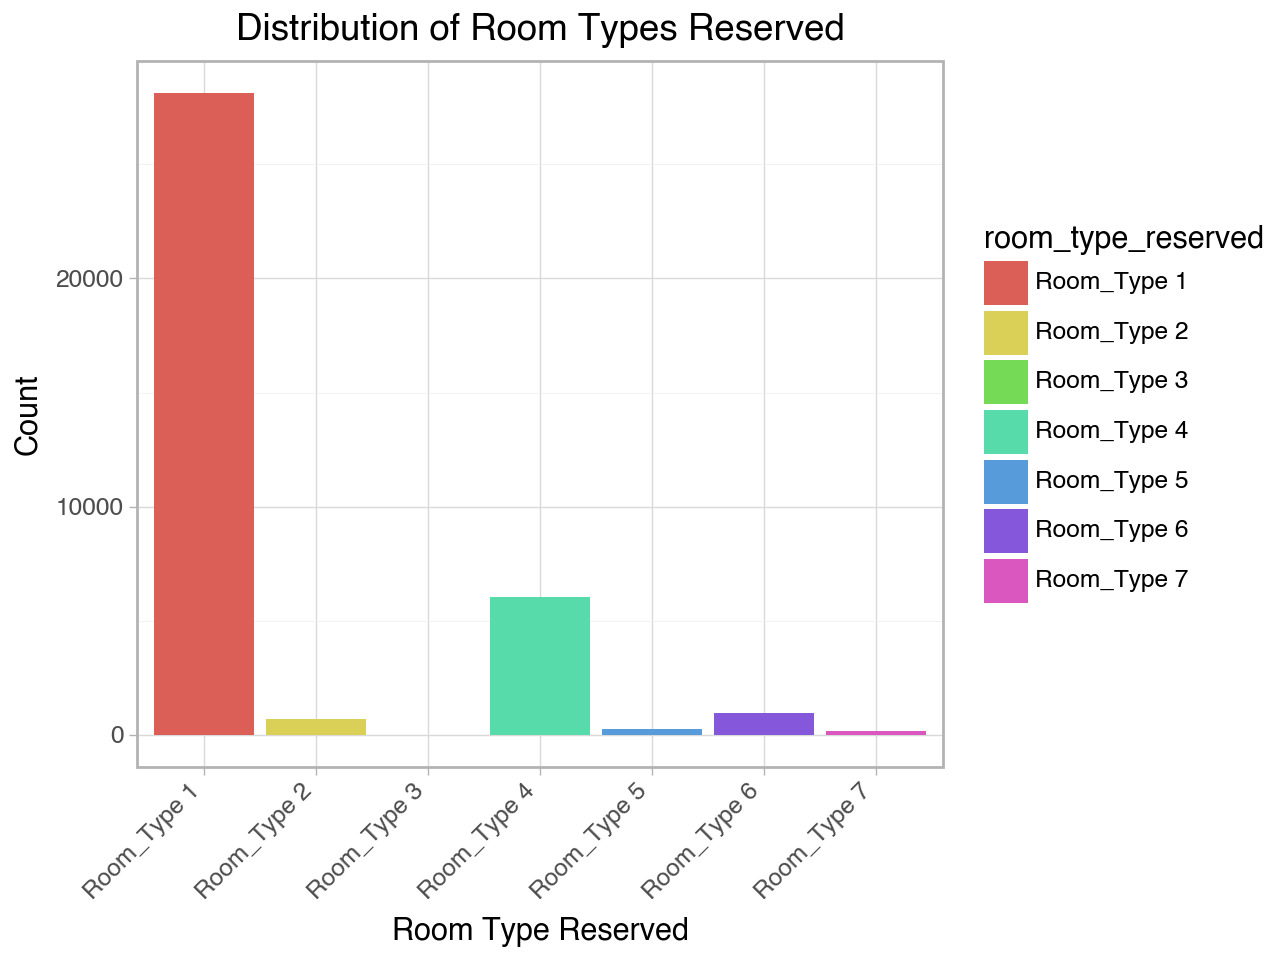

In [232]:
plot = (
    ggplot(df, aes(x='room_type_reserved', fill='room_type_reserved')) +
    geom_bar() +
    labs(title="Distribution of Room Types Reserved", x="Room Type Reserved", y="Count") +
    theme_light() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2666584954.py:30: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


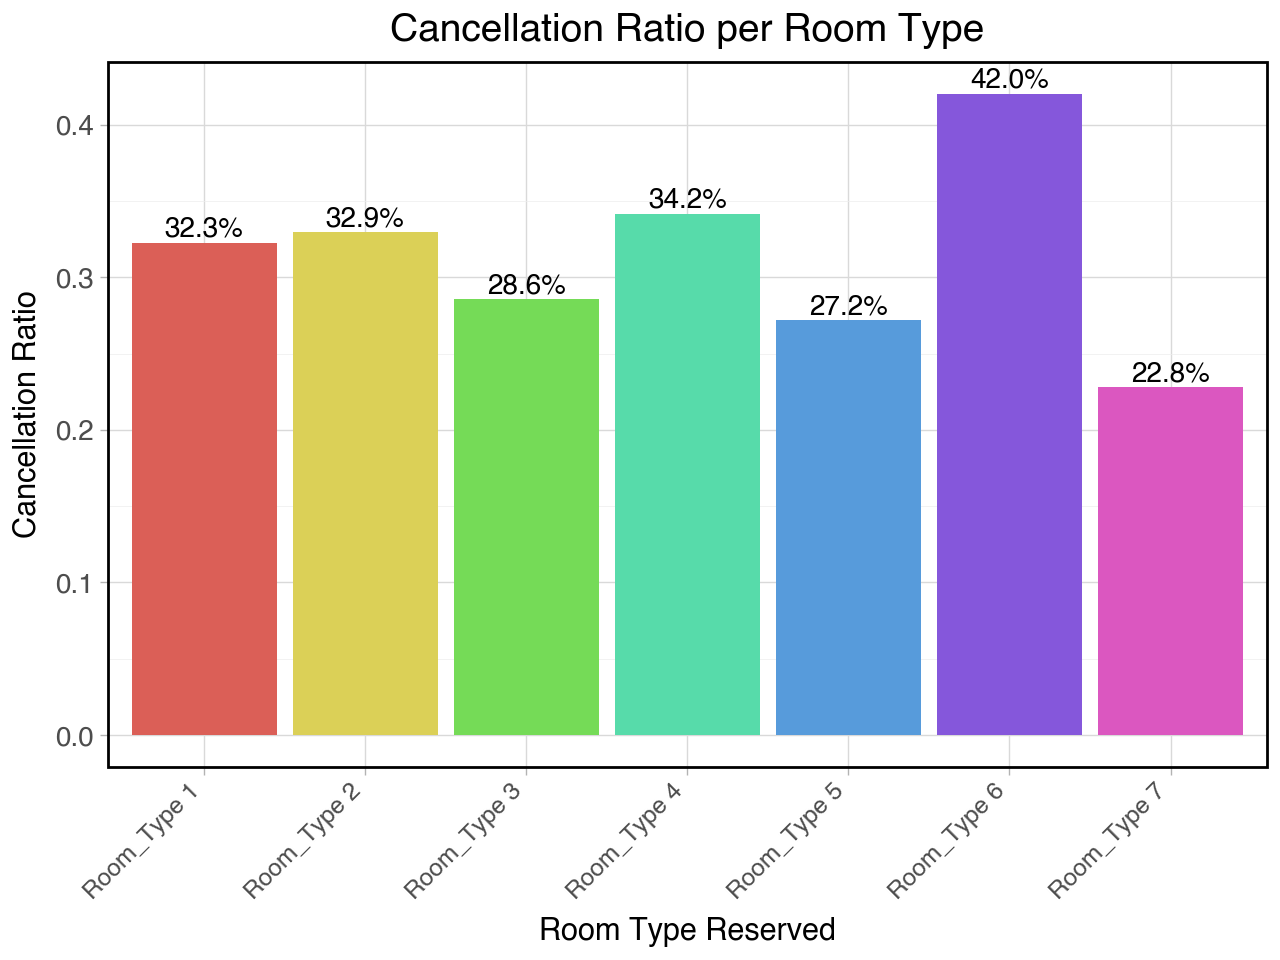

In [233]:

cancellation_data = (
    df.groupby('room_type_reserved')['booking_status']
    .apply(lambda x: (x == 'Canceled').sum() / len(x))
    .reset_index(name='cancellation_ratio')
)

cancellation_data['cancellation_ratio_percentage'] = (cancellation_data['cancellation_ratio'] * 100).round(1)

plot = (
    ggplot(cancellation_data, aes(x='room_type_reserved', y='cancellation_ratio', fill='room_type_reserved')) +
    geom_col(show_legend=False) +
    geom_text(
        aes(label=cancellation_data['cancellation_ratio_percentage'].astype(str) + '%'),
        va='bottom', size=10
    ) +
    labs(
        title="Cancellation Ratio per Room Type",
        x="Room Type Reserved",
        y="Cancellation Ratio"
    ) +    theme_light() +
    
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold'),
        panel_background=element_rect(fill='white'),  # White background
        panel_border=element_rect(color='black')      # Border for clarity
    )
)
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2930228099.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


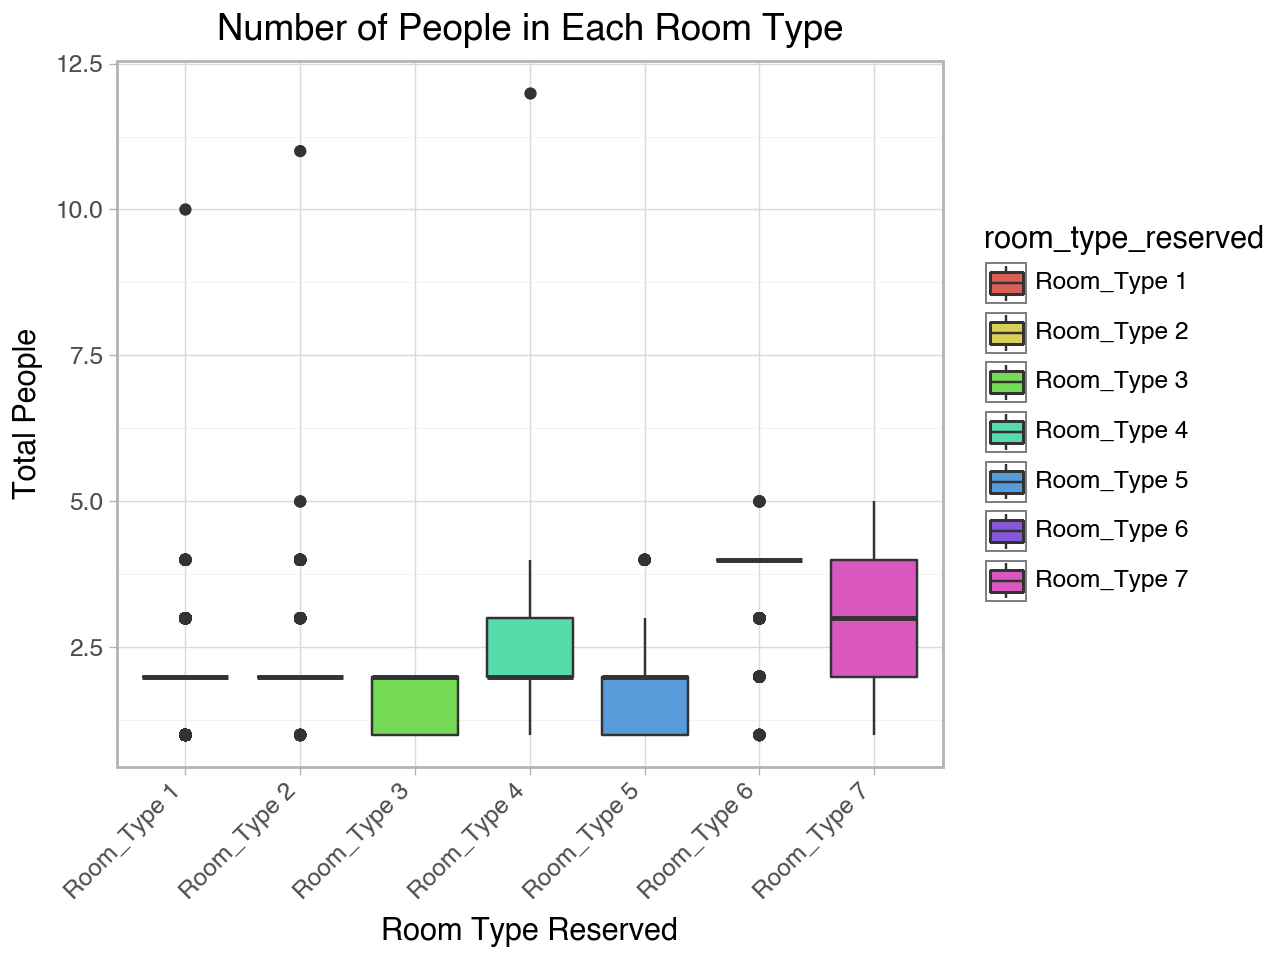

In [234]:
plot = (
    ggplot(df, aes(x='room_type_reserved', y='total_people', fill='room_type_reserved')) +
    geom_boxplot() +
    labs(title="Number of People in Each Room Type", x="Room Type Reserved", y="Total People") +
    theme_light() +  # White background with light gridlines
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)
print(plot)

<!-- README_INCLUDE -->
- **Room Type**: We can see that for room types, the majority are of type 1 and 4. Room types 1, 2, and 4 seem to be booked by two people, while types 3 and 5 are booked by fewer people (possibly more individual guests), and types 6 and 7 are booked by 3 or more people. We observe that rooms with fewer guests on average have lower cancellation ratios.

### Number of people in the room: adults & total people (including kids)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2823819715.py:12: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


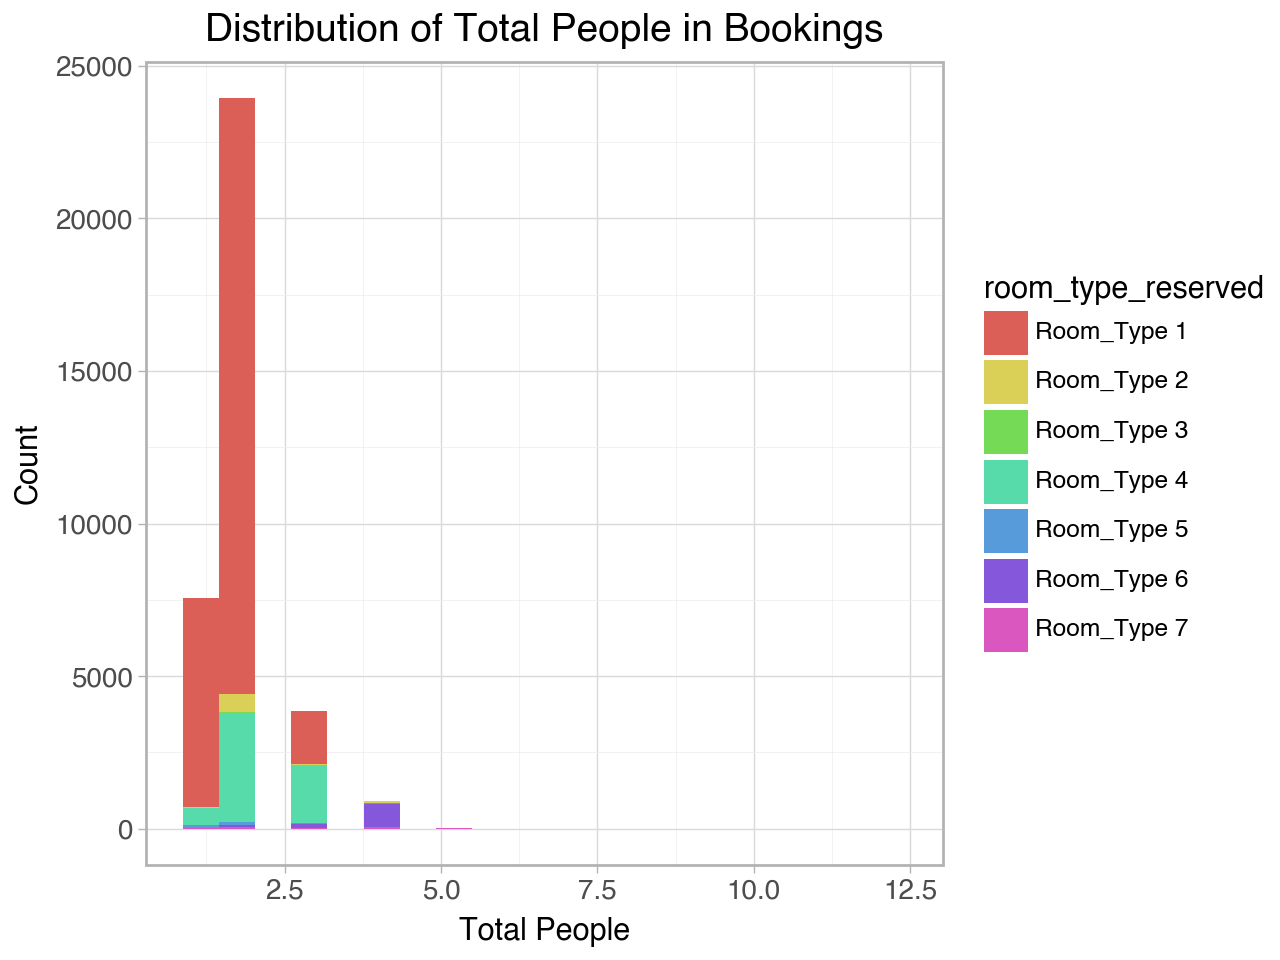

In [235]:
plot = (
    ggplot(df, aes(x='total_people', fill='room_type_reserved')) +
    geom_histogram(bins=20) +
    labs(title="Distribution of Total People in Bookings", x="Total People", y="Count") +
    theme_light() +
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/4102422279.py:28: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


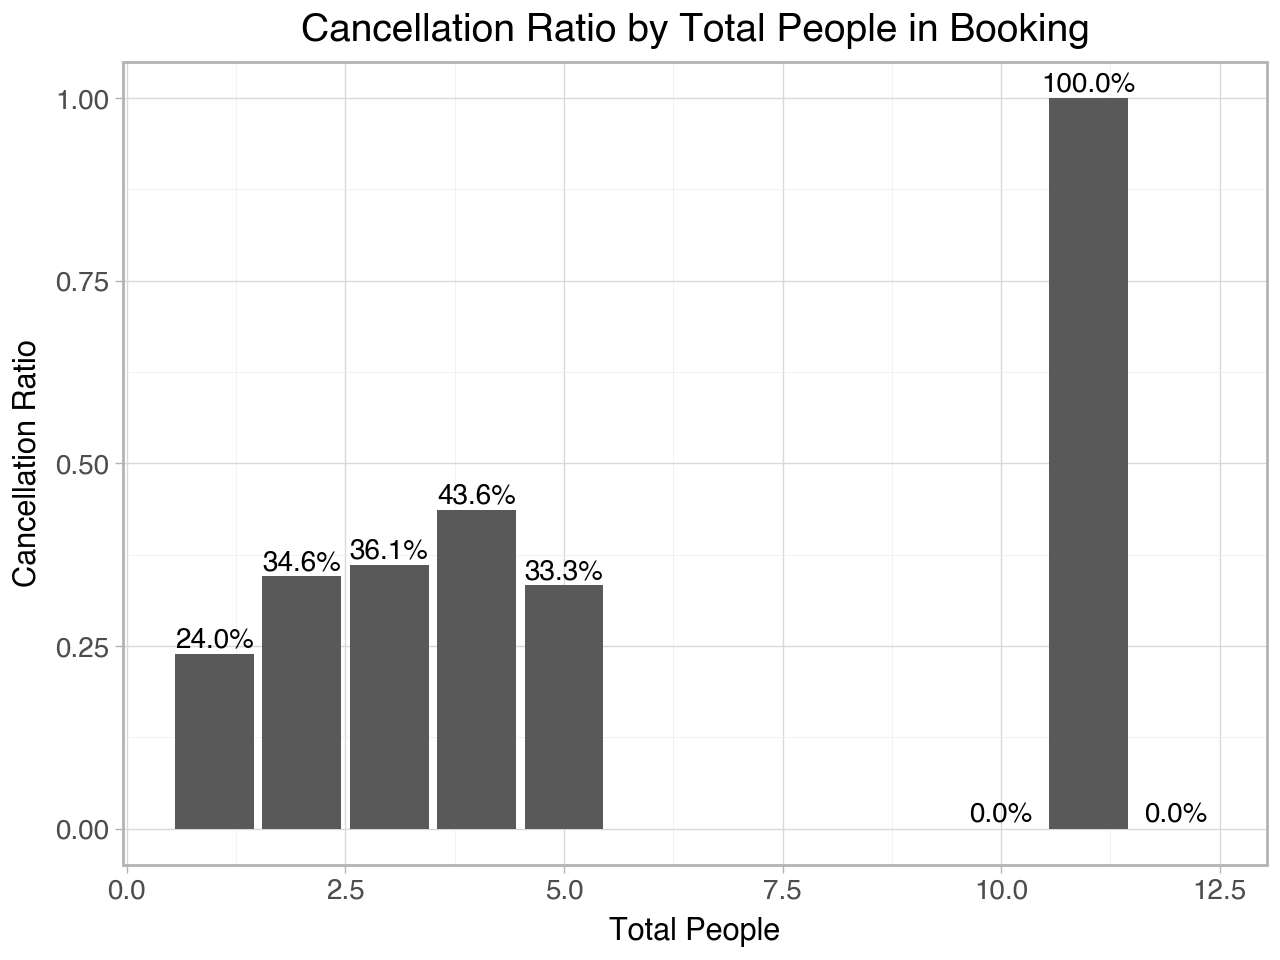

In [236]:
cancellation_data = (
    df.groupby('total_people')['booking_status']
    .apply(lambda x: (x == 'Canceled').sum() / len(x))
    .reset_index(name='cancellation_ratio')
)

cancellation_data['cancellation_ratio_percentage'] = (cancellation_data['cancellation_ratio'] * 100).round(1)

plot = (
    ggplot(cancellation_data, aes(x='total_people', y='cancellation_ratio')) +
    geom_col() +
    geom_text(
        aes(label=cancellation_data['cancellation_ratio_percentage'].astype(str) + '%'),
        va='bottom', size=10
    ) +
    labs(
        title="Cancellation Ratio by Total People in Booking",
        x="Total People",
        y="Cancellation Ratio"
    ) +
    theme_light() +
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)

In [237]:
df = df[df['total_people'] <= 5]

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/3167269838.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


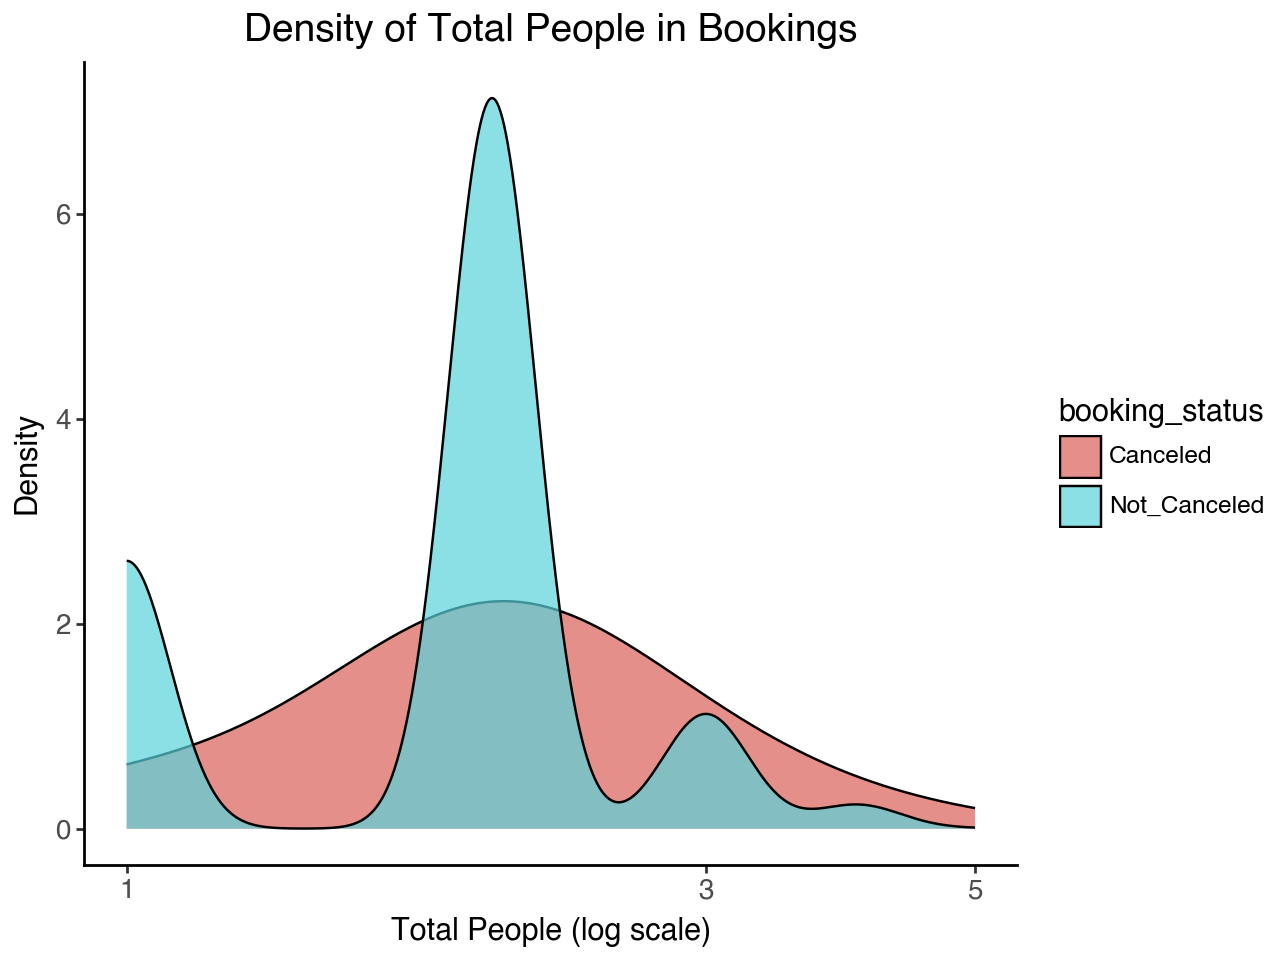

In [238]:

plot = (
    ggplot(df, aes(x='total_people', fill='booking_status')) +
    geom_density(alpha=0.7) +  # Density plot with alpha transparency
    scale_x_log10() +  # Logarithmic scale for x-axis
    labs(
        title="Density of Total People in Bookings",
        x="Total People (log scale)",
        y="Density"
    ) +
    theme_classic() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)


<!-- README_INCLUDE -->

- **Total People**: The majority of bookings are for two people, followed by bookings for one and three people. Interestingly, single-person bookings tend to have fewer cancellations compared to bookings with more people. This could potentially be linked to work-related trips or other factors.


### Lead time

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/700389438.py:7: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


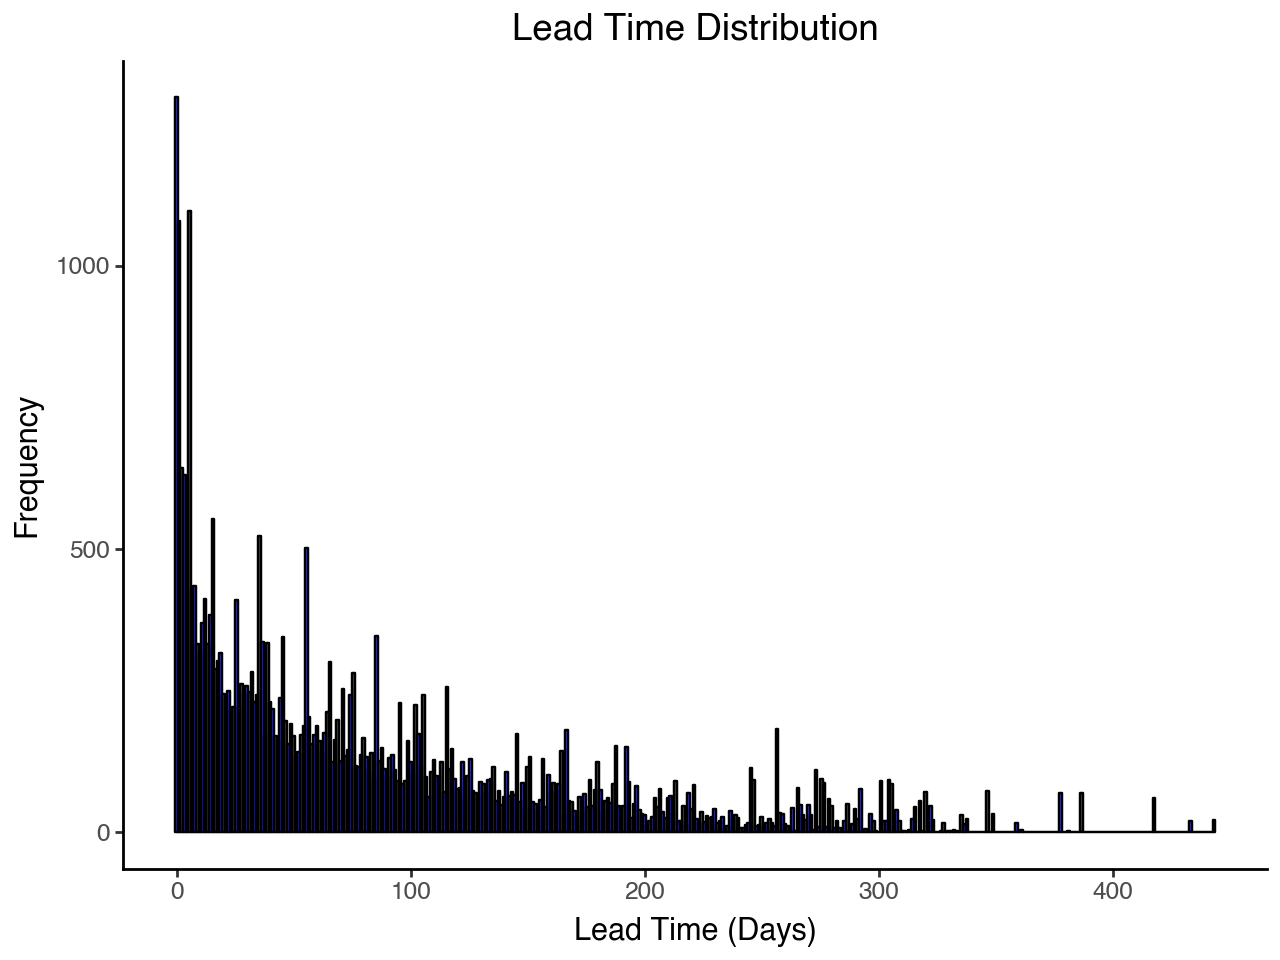

In [239]:

plot = (
    ggplot(df, aes(x='lead_time')) +
    geom_histogram(bins=400, fill='blue', alpha=0.7, color='black') +
    labs(title="Lead Time Distribution", x="Lead Time (Days)", y="Frequency") +
    theme_classic()
)
print(plot)

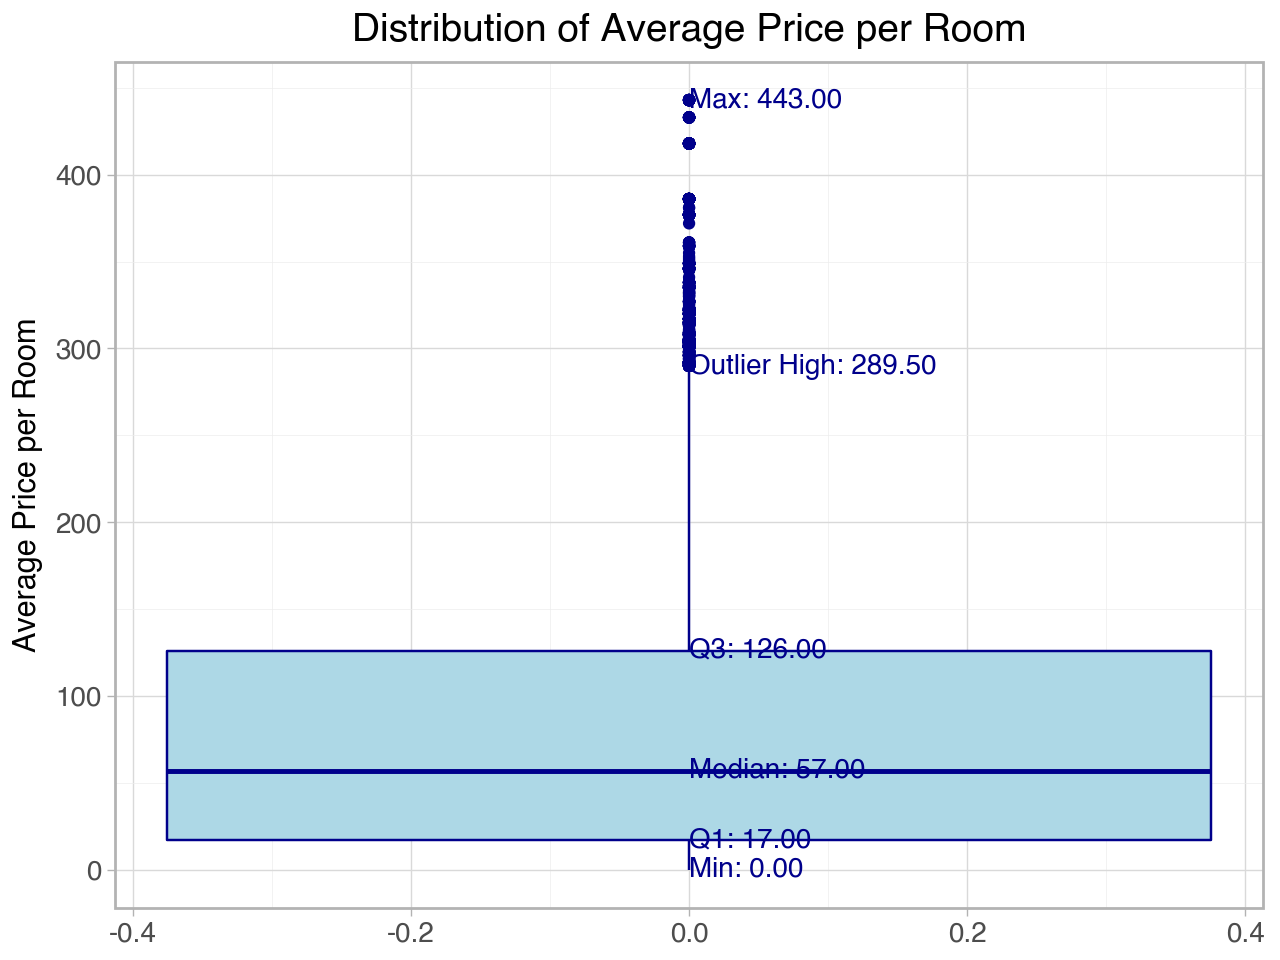

In [240]:
from plotnine import (
    ggplot, aes, geom_boxplot, geom_text, labs, theme_light, theme, element_text
)

quartiles = df['lead_time'].quantile([0.25, 0.5, 0.75])
median = quartiles[0.5]
q1 = quartiles[0.25]
q3 = quartiles[0.75]
outlow = q1 - 1.5 * (q3 - q1)
outhigh = q3 + 1.5 * (q3 - q1)
min_value = df['lead_time'].min()
max_value = df['lead_time'].max()

labels_data = pd.DataFrame({
    'x': [0, 0, 0, 0, 0, 0],  # Slight offset from the box to position labels next to the lines
    'y': [median, q1, q3, min_value, max_value, outhigh],
    'label': [
        f'Median: {median:.2f}',
        f'Q1: {q1:.2f}',
        f'Q3: {q3:.2f}',
        f'Min: {min_value:.2f}',
        f'Max: {max_value:.2f}',
        f'Outlier High: {outhigh:.2f}'
    ]
})

plot = (
    ggplot(df, aes(y='lead_time')) +  # Only the y-axis is the avg price per room
    geom_boxplot(fill='lightblue', color='darkblue') +  # Boxplot with light blue fill and dark blue outline
    geom_text(
        aes(x='x', y='y', label='label'),  # Set the x, y, and label aesthetics
        data=labels_data,  # Pass the labels_data DataFrame for the label positions
        va='center', ha='left', size=10, color='darkblue', fontweight='bold'
    ) +
    labs(
        title="Distribution of Average Price per Room",
        x="",
        y="Average Price per Room"
    ) +
    theme_light() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),  # No x-axis labels as there's only one variable
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

plot.show()


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/3049974672.py:29: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/opt/anaconda3/envs/ml-zoomcamp39/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


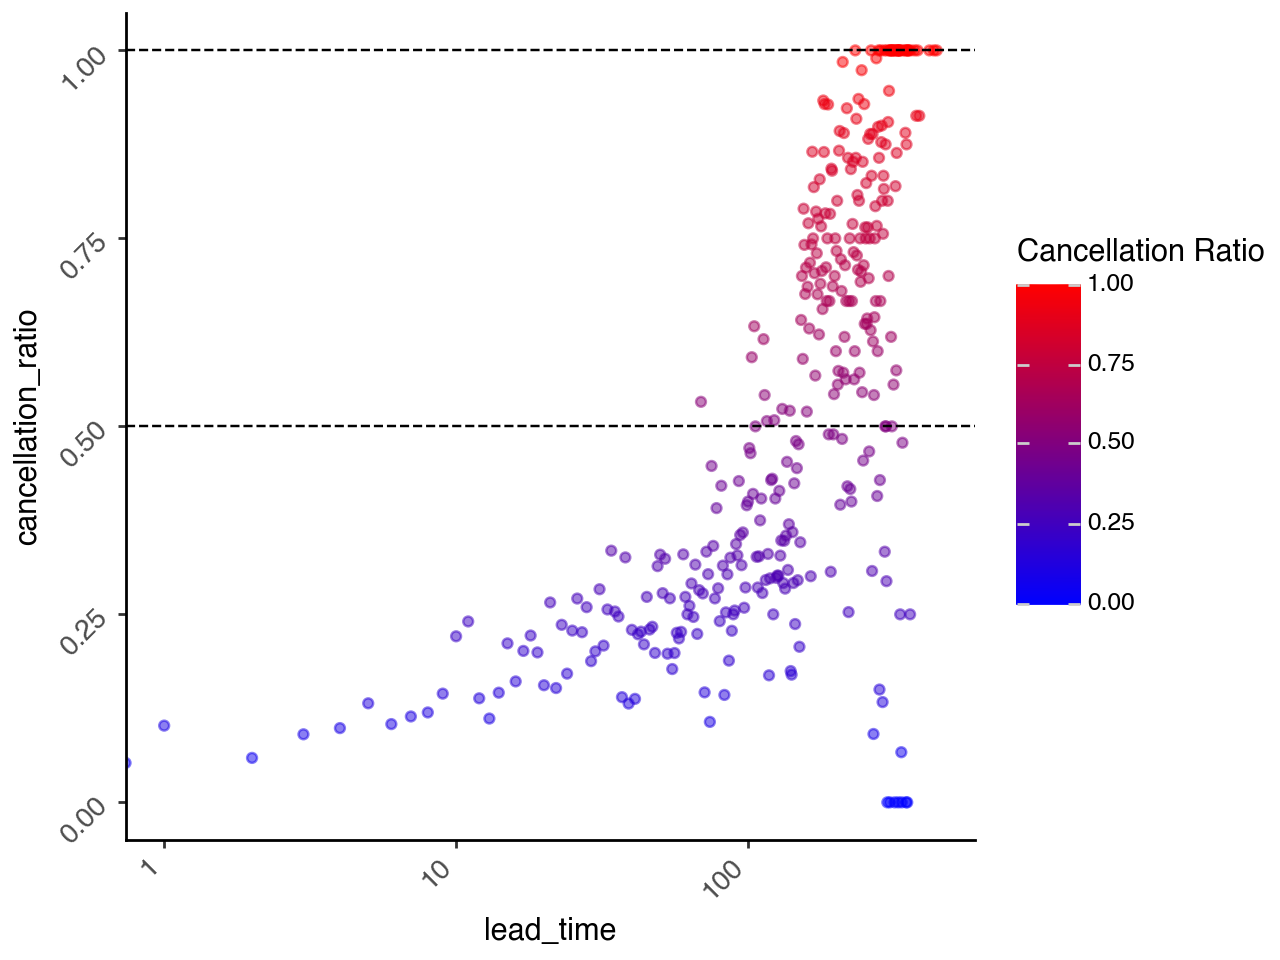

In [241]:
from plotnine import (
    ggplot, aes, geom_point, scale_colour_gradient, scale_x_log10, scale_y_log10, 
    geom_hline, labs, theme_classic, theme, element_text, scale_y_continuous
)

cancellation_data = (
    df.groupby('lead_time')['booking_status']
    .apply(lambda x: (x == 'Canceled').sum() / len(x))
    .reset_index(name='cancellation_ratio')
)

plot = (
    ggplot(cancellation_data, aes(x='lead_time', y='cancellation_ratio', color='cancellation_ratio')) +
    geom_point(alpha=0.5) +  # Scatter plot with alpha transparency
    scale_colour_gradient(low="blue", high="red") +  # Color gradient from blue to red
    scale_x_log10() +  # Logarithmic scale for x-axis
    scale_y_continuous(limits=(0, 1)) +  # Set the y-axis limits from 0 to 1
    geom_hline(yintercept=0.5, linetype='dashed') +  # Horizontal line at y=0.5
    geom_hline(yintercept=1, linetype='dashed') +  # Horizontal line at y=1
    labs(color="Cancellation Ratio") +  # Label for the color scale
    theme_classic() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10, angle=45, ha='right'),  # Rotate x-axis labels
        axis_text_y=element_text(size=10, angle=45, ha='right'),  # Rotate y-axis labels
        plot_title=element_text(size=14, weight='bold')
    )
)

print(plot)


<!-- README_INCLUDE -->

- **Lead Time**: The distribution of this property, which indicates how far in advance bookings are made, is particularly interesting. We observe that as the booking date approaches, the number of bookings increases, with the median lead time being 60 days. However, unexpectedly, the cancellation ratio also rises with longer lead times, suggesting that bookings made further in advance are more likely to be canceled.


### price per room

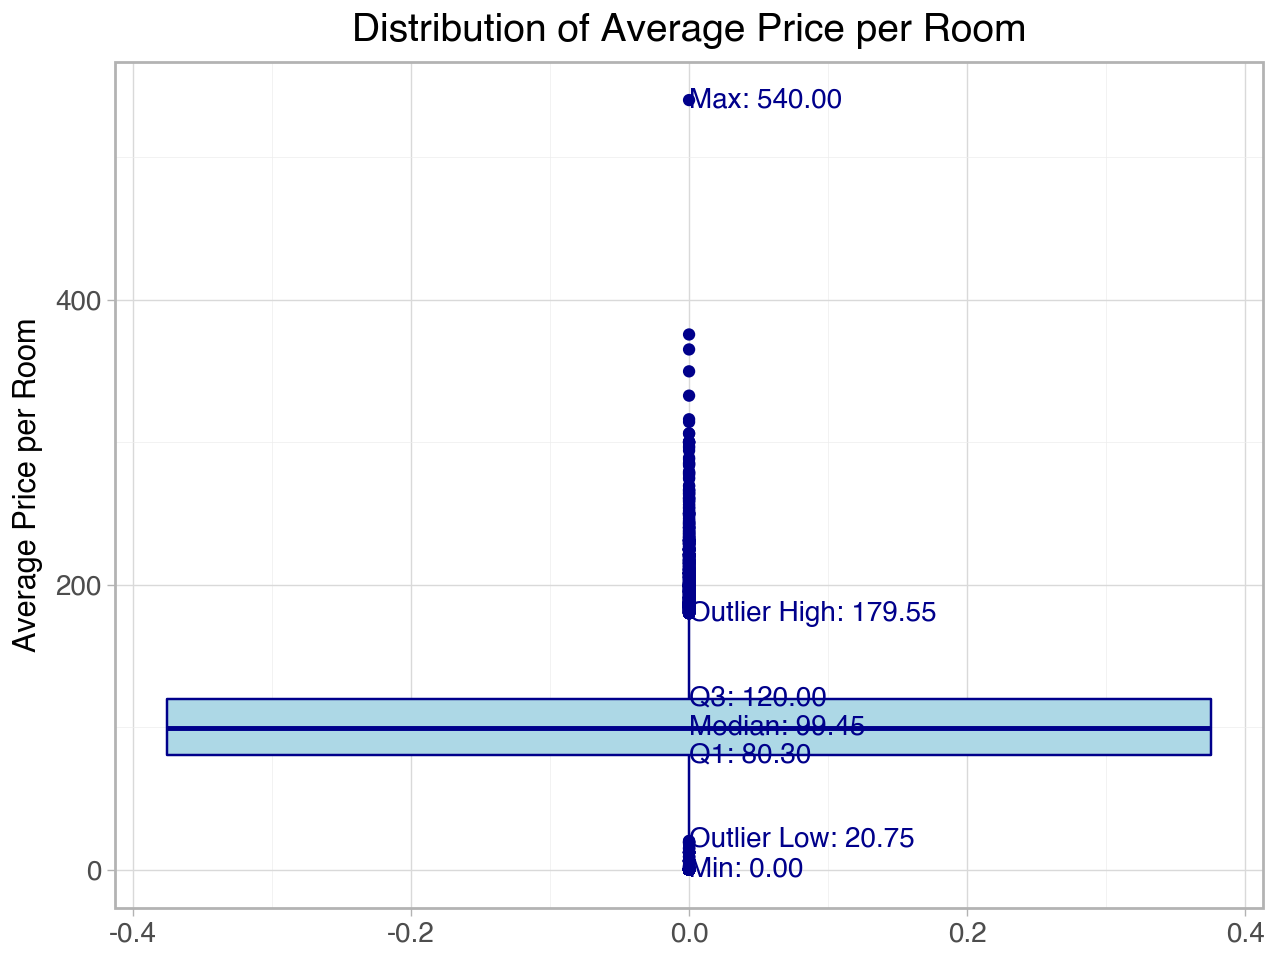

In [242]:
from plotnine import (
    ggplot, aes, geom_boxplot, geom_text, labs, theme_light, theme, element_text
)

quartiles = df['avg_price_per_room'].quantile([0.25, 0.5, 0.75])
median = quartiles[0.5]
q1 = quartiles[0.25]
q3 = quartiles[0.75]
outlow = q1 - 1.5 * (q3 - q1)
outhigh = q3 + 1.5 * (q3 - q1)
min_value = df['avg_price_per_room'].min()
max_value = df['avg_price_per_room'].max()

labels_data = pd.DataFrame({
    'x': [0, 0, 0, 0, 0, 0, 0],  # Slight offset from the box to position labels next to the lines
    'y': [median, q1, q3, min_value, max_value, outlow, outhigh],
    'label': [
        f'Median: {median:.2f}',
        f'Q1: {q1:.2f}',
        f'Q3: {q3:.2f}',
        f'Min: {min_value:.2f}',
        f'Max: {max_value:.2f}',
        f'Outlier Low: {outlow:.2f}',
        f'Outlier High: {outhigh:.2f}'
    ]
})

plot = (
    ggplot(df, aes(y='avg_price_per_room')) +  # Only the y-axis is the avg price per room
    geom_boxplot(fill='lightblue', color='darkblue') +  # Boxplot with light blue fill and dark blue outline
    geom_text(
        aes(x='x', y='y', label='label'),  # Set the x, y, and label aesthetics
        data=labels_data,  # Pass the labels_data DataFrame for the label positions
        va='center', ha='left', size=10, color='darkblue', fontweight='bold'
    ) +
    labs(
        title="Distribution of Average Price per Room",
        x="",
        y="Average Price per Room"
    ) +
    theme_light() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),  # No x-axis labels as there's only one variable
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

plot.show()


<!-- README_INCLUDE -->

- **Price per Room**: On average, users pay 99 euros per room per day, with the first quartile at 80 euros and the third quartile at 120 euros. There are also some extreme high values in the price distribution. We see a positive correlation between higher prices and higher cancellation ratio, but is not super strong.


In [243]:
df = df[(df['avg_price_per_room'] <= outhigh) & (df['avg_price_per_room'] >= outlow)]

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/3910748991.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


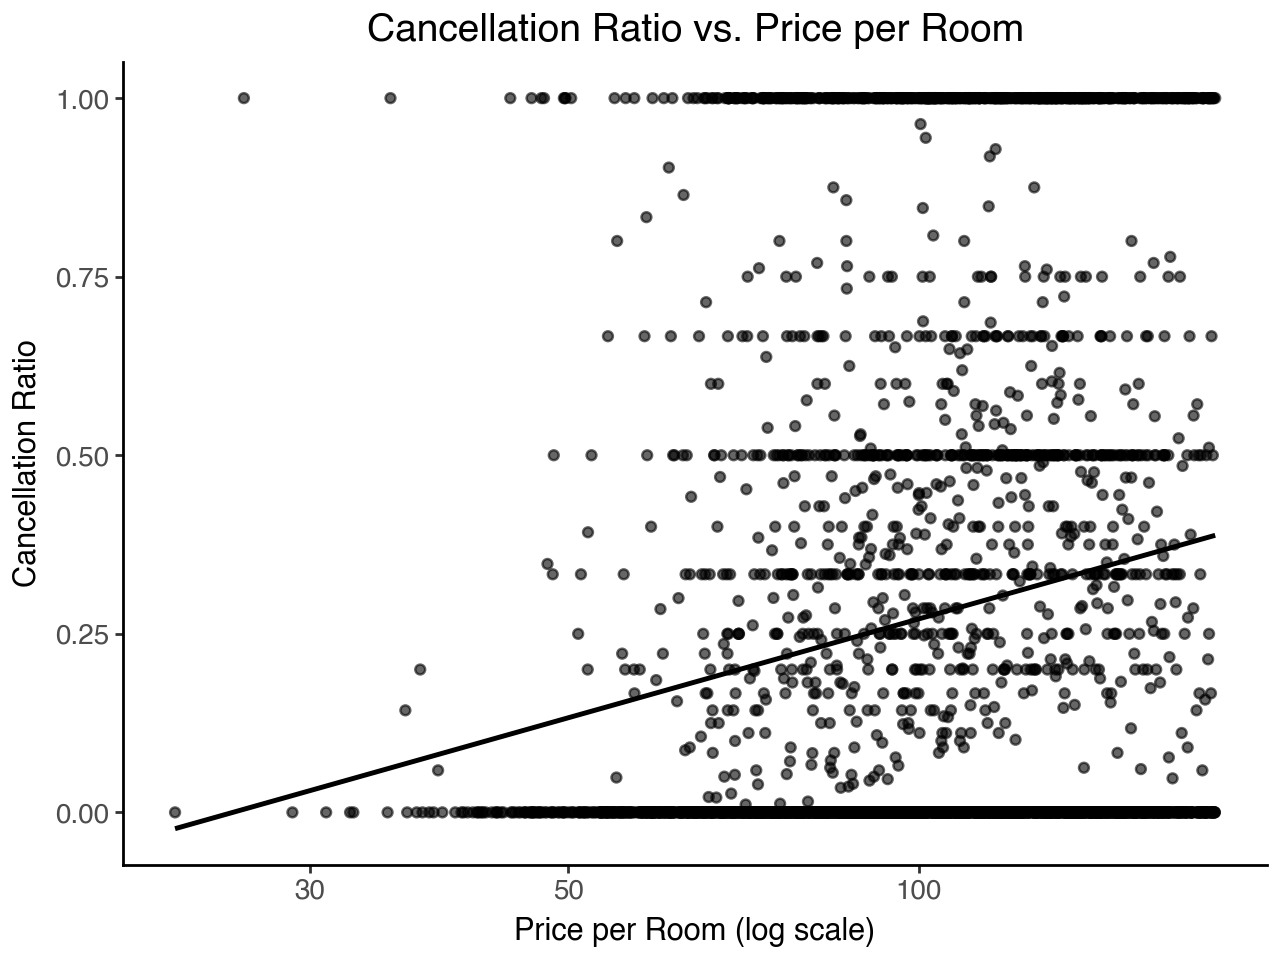

In [244]:
from plotnine import ggplot, aes, geom_point, geom_smooth, scale_x_log10, labs, theme_classic, theme, element_text, facet_wrap

cancellation_data = (   
    df.groupby('avg_price_per_room')['booking_status']
    .apply(lambda x: (x == 'Canceled').sum() / len(x))
    .reset_index(name='cancellation_ratio')
)

plot = (
    ggplot(cancellation_data, aes(x='avg_price_per_room', y='cancellation_ratio')) +
    geom_point(alpha=0.6) +  # Scatter plot with transparency
    geom_smooth(method='lm', se=False, color='black') +  # Add a linear regression line
    scale_x_log10() +  # Logarithmic scale for the x-axis
    labs(
        title="Cancellation Ratio vs. Price per Room",
        x="Price per Room (log scale)",
        y="Cancellation Ratio"
    ) +
    theme_classic() +  # Classic theme for a clean background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

print(plot)


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/1650215091.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


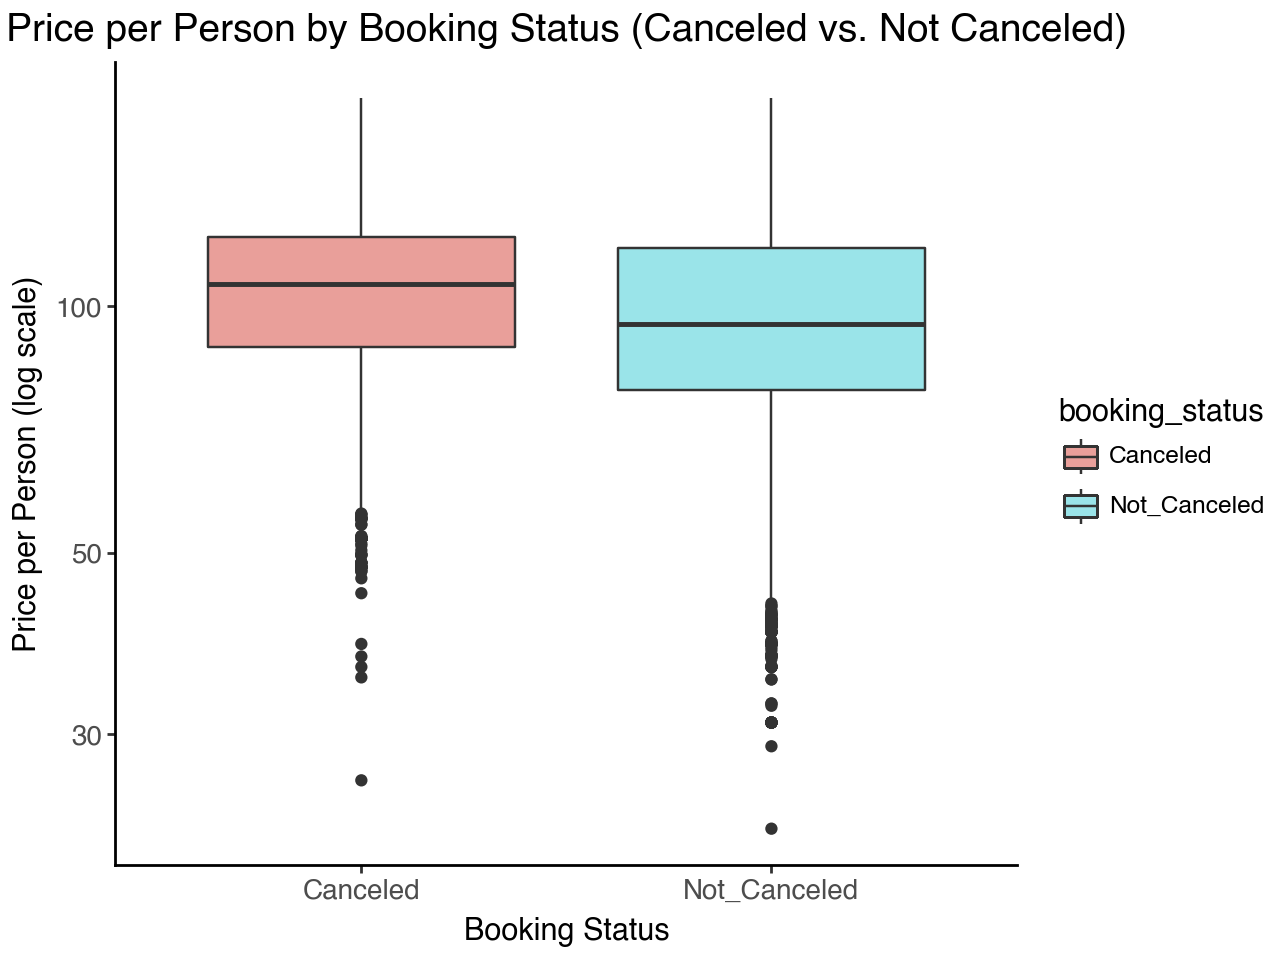

In [245]:
from plotnine import geom_boxplot

plot_boxplot = (
    ggplot(df, aes(x='booking_status', y='avg_price_per_room', fill='booking_status')) +
    geom_boxplot(alpha=0.6) +  # Boxplot with transparency
    scale_y_log10() +  # Logarithmic scale for better visualization if price range is wide
    labs(
        title="Price per Person by Booking Status (Canceled vs. Not Canceled)",
        x="Booking Status",
        y="Price per Person (log scale)"
    ) +
    theme_classic() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

print(plot_boxplot)


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2595410871.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


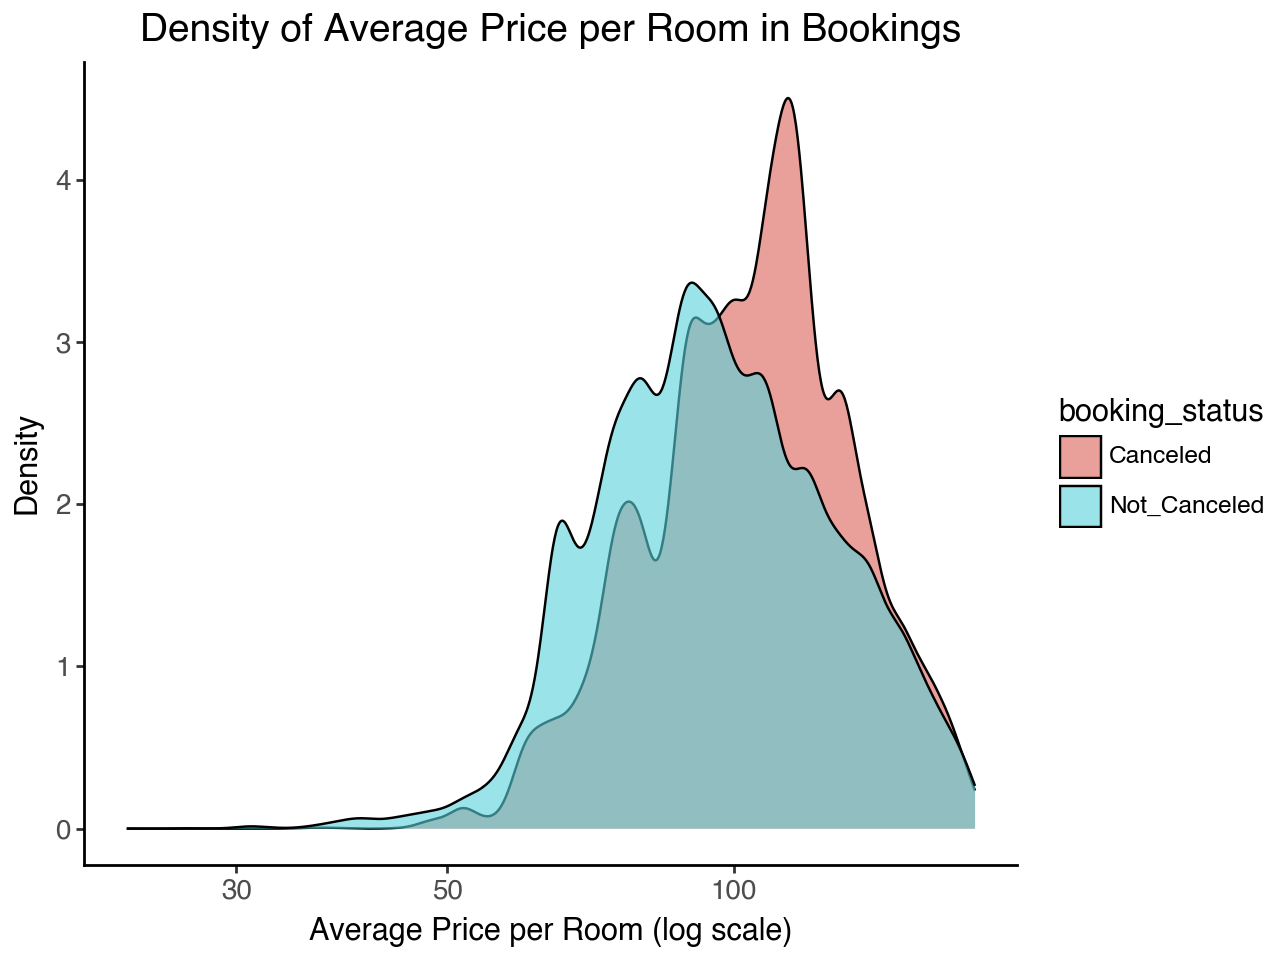

In [246]:

plot = (
    ggplot(df, aes(x='avg_price_per_room', fill='booking_status')) +
    geom_density(alpha=0.6) +  # Density plot with alpha transparency
    scale_x_log10() +  # Logarithmic scale for x-axis
    labs(
        title="Density of Average Price per Room in Bookings",
        x="Average Price per Room (log scale)",
        y="Density"
    ) +
    theme_classic() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2851474693.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


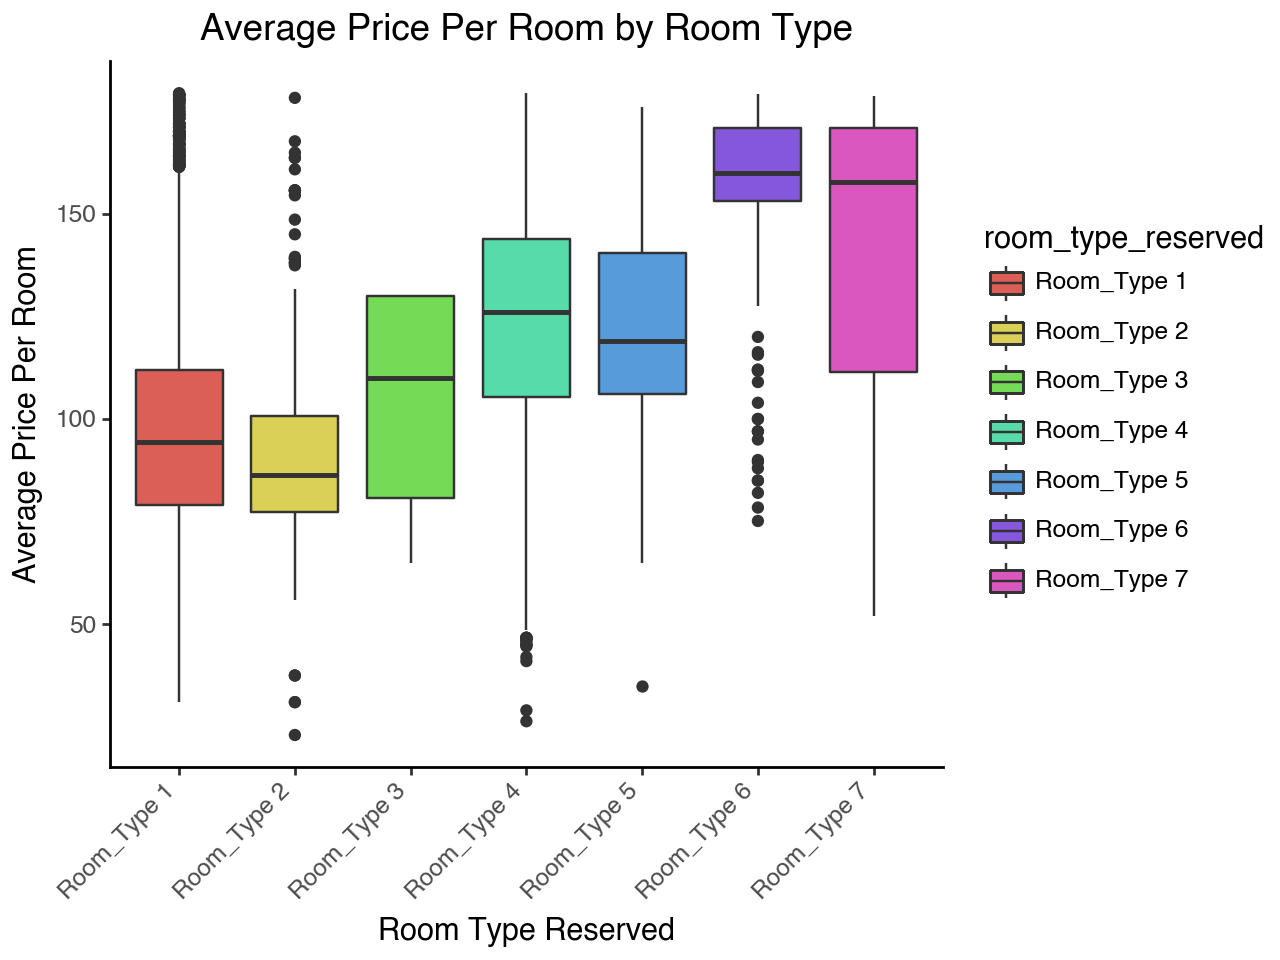

In [247]:

plot = (
    ggplot(df, aes(x='room_type_reserved', y='avg_price_per_room', fill='room_type_reserved')) +
    geom_boxplot() +
    labs(title="Average Price Per Room by Room Type", x="Room Type Reserved", y="Average Price Per Room") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)
print(plot)

### Average price per person

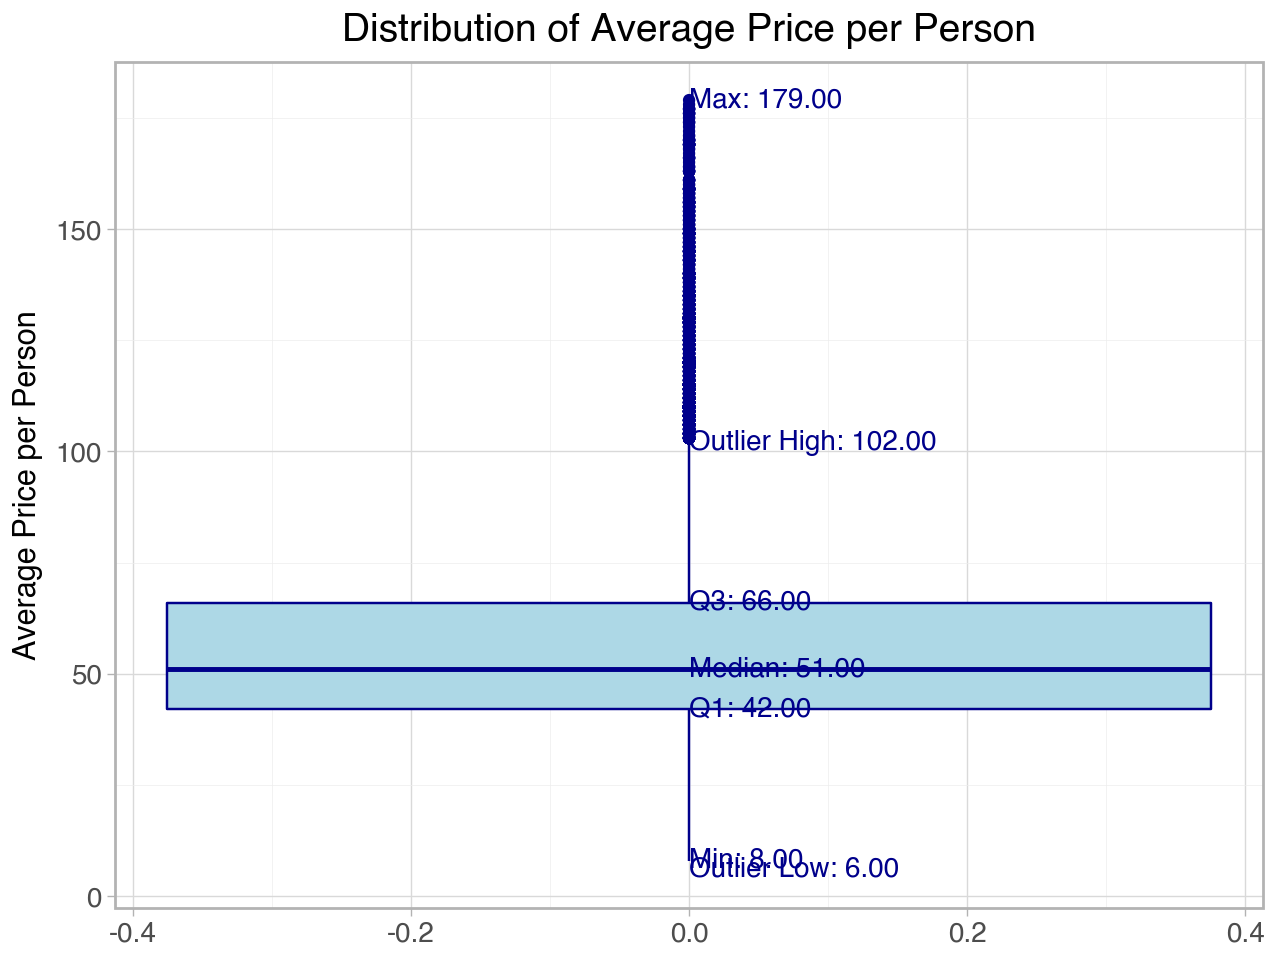

In [248]:
from plotnine import (
    ggplot, aes, geom_boxplot, geom_text, labs, theme_light, theme, element_text
)

quartiles = df['price_per_person'].quantile([0.25, 0.5, 0.75])
median = quartiles[0.5]
q1 = quartiles[0.25]
q3 = quartiles[0.75]
outlow = q1 - 1.5 * (q3 - q1)
outhigh = q3 + 1.5 * (q3 - q1)
min_value = df['price_per_person'].min()
max_value = df['price_per_person'].max()

labels_data = pd.DataFrame({
    'x': [0, 0, 0, 0, 0, 0, 0],  # Slight offset from the box to position labels next to the lines
    'y': [median, q1, q3, min_value, max_value, outlow, outhigh],
    'label': [
        f'Median: {median:.2f}',
        f'Q1: {q1:.2f}',
        f'Q3: {q3:.2f}',
        f'Min: {min_value:.2f}',
        f'Max: {max_value:.2f}',
        f'Outlier Low: {outlow:.2f}',
        f'Outlier High: {outhigh:.2f}'
    ]
})

plot = (
    ggplot(df, aes(y='price_per_person')) +  # Only the y-axis is the avg price per room
    geom_boxplot(fill='lightblue', color='darkblue') +  # Boxplot with light blue fill and dark blue outline
    geom_text(
        aes(x='x', y='y', label='label'),  # Set the x, y, and label aesthetics
        data=labels_data,  # Pass the labels_data DataFrame for the label positions
        va='center', ha='left', size=10, color='darkblue', fontweight='bold'
    ) +
    labs(
        title="Distribution of Average Price per Person",
        x="",
        y="Average Price per Person"
    ) +
    theme_light() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),  # No x-axis labels as there's only one variable
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

plot.show()


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/3563474467.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


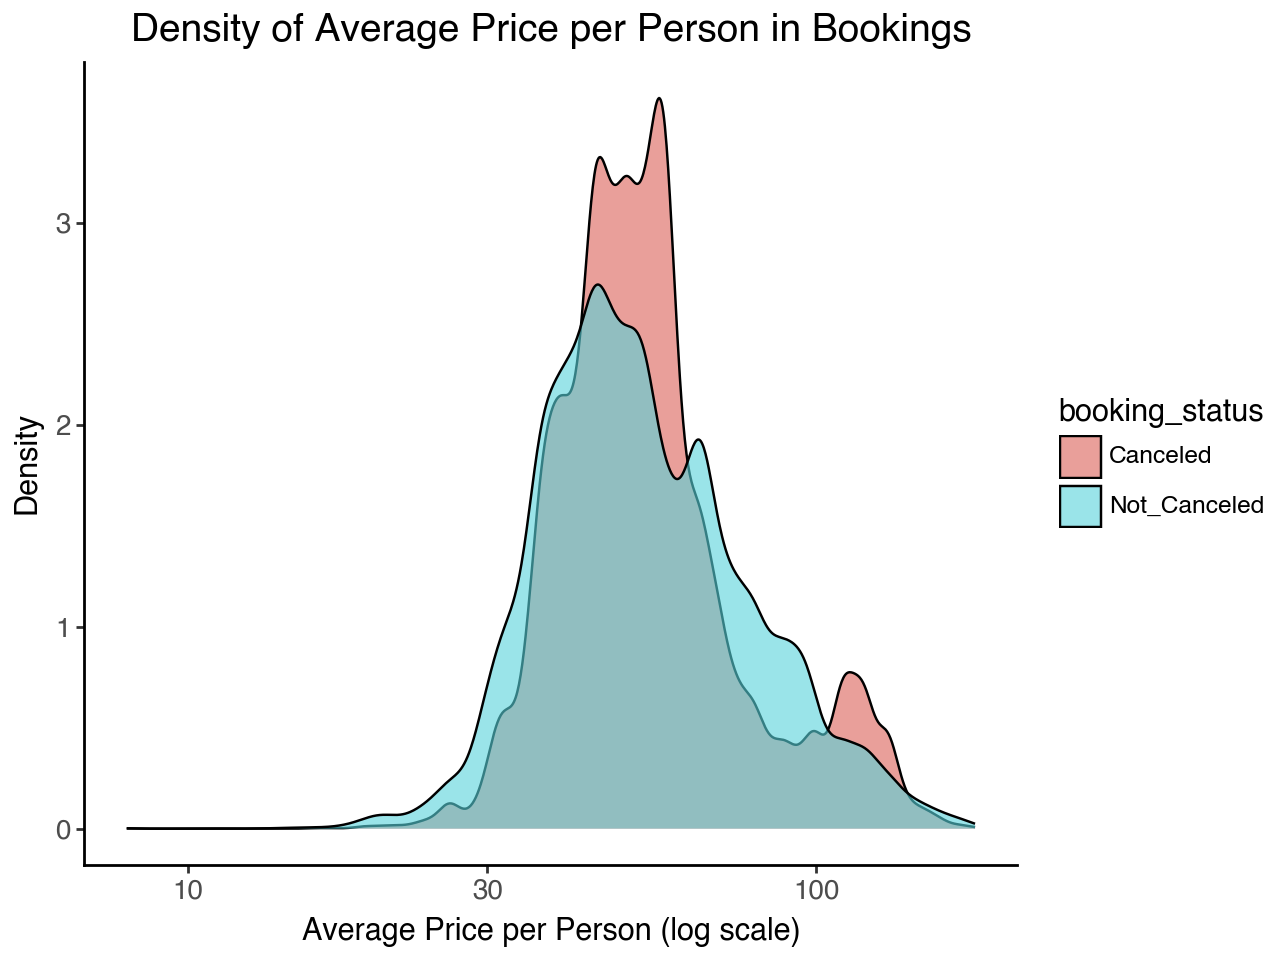

In [249]:

plot = (
    ggplot(df, aes(x='price_per_person', fill='booking_status')) +
    geom_density(alpha=0.6) +  # Density plot with alpha transparency
    scale_x_log10() +  # Logarithmic scale for x-axis
    labs(
        title="Density of Average Price per Person in Bookings",
        x="Average Price per Person (log scale)",
        y="Density"
    ) +
    theme_classic() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/3651930578.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


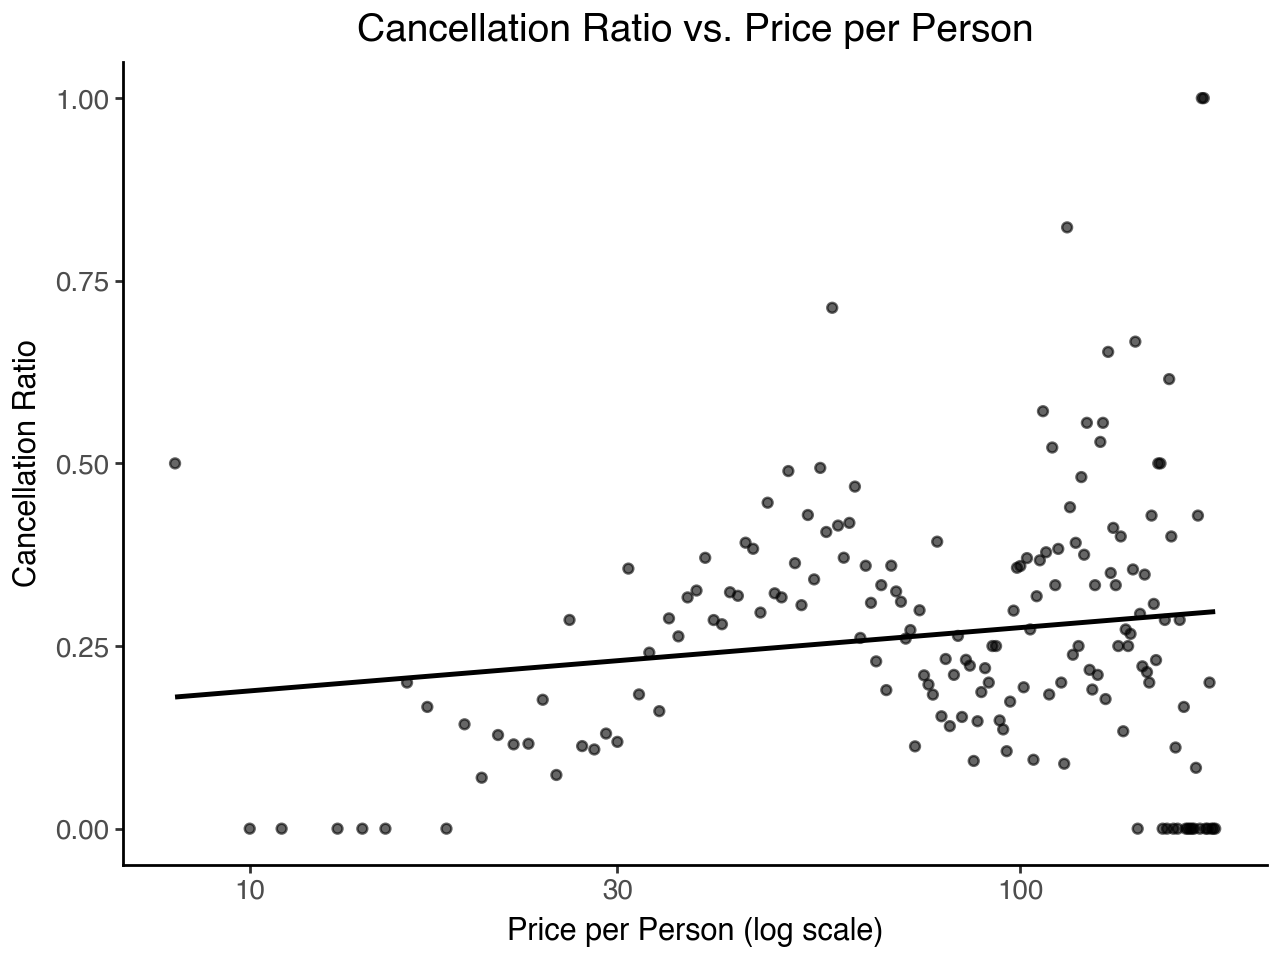

In [250]:
from plotnine import ggplot, aes, geom_point, geom_smooth, scale_x_log10, labs, theme_classic, theme, element_text, facet_wrap

cancellation_data = (   
    df.groupby('price_per_person')['booking_status']
    .apply(lambda x: (x == 'Canceled').sum() / len(x))
    .reset_index(name='cancellation_ratio')
)

plot = (
    ggplot(cancellation_data, aes(x='price_per_person', y='cancellation_ratio')) +
    geom_point(alpha=0.6) +  # Scatter plot with transparency
    geom_smooth(method='lm', se=False, color='black') +  # Add a linear regression line
    scale_x_log10() +  # Logarithmic scale for the x-axis
    labs(
        title="Cancellation Ratio vs. Price per Person",
        x="Price per Person (log scale)",
        y="Cancellation Ratio"
    ) +
    theme_classic() +  # Classic theme for a clean background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/1397642637.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


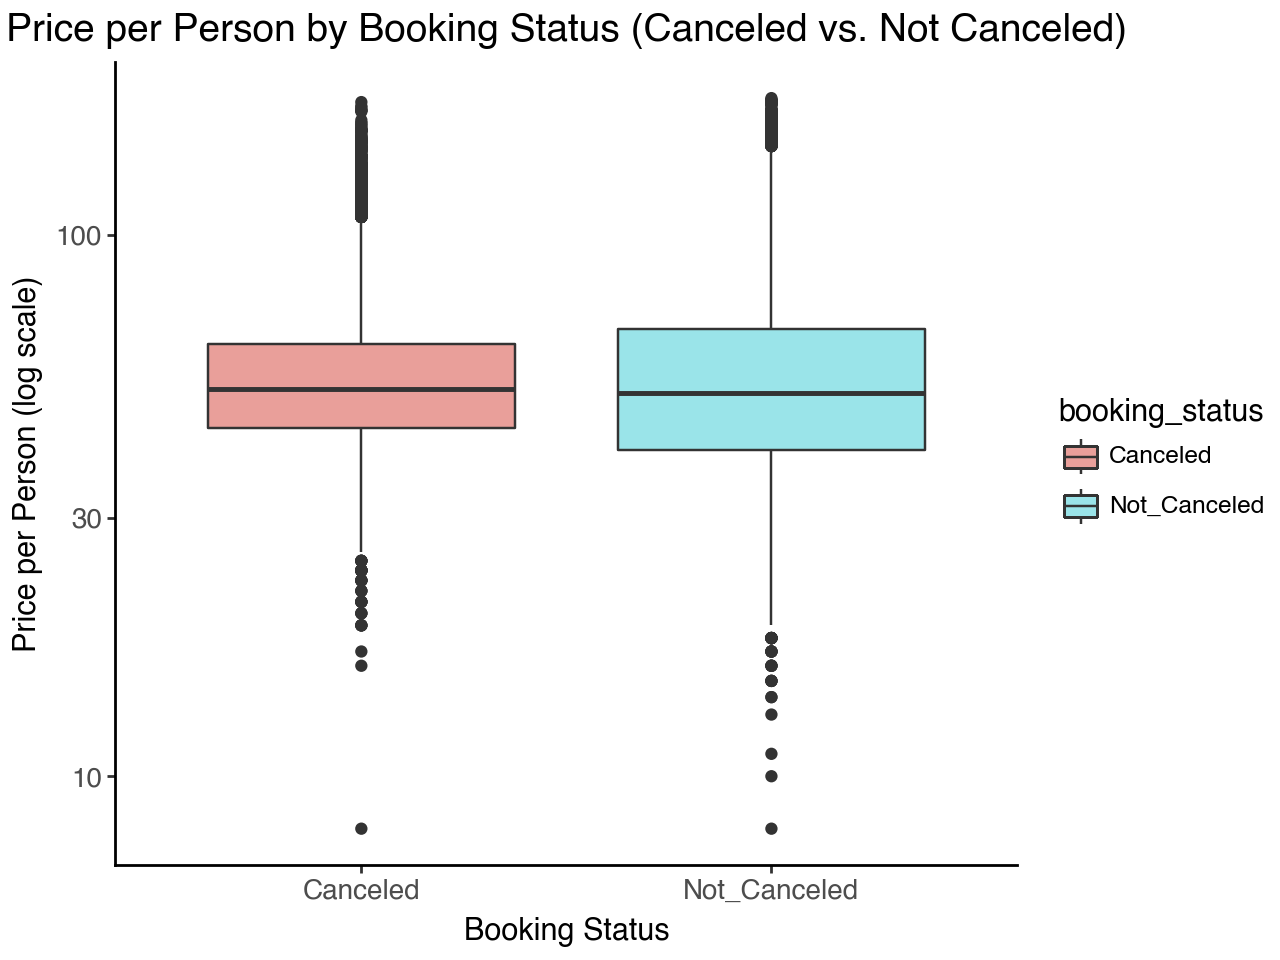

In [251]:
from plotnine import geom_boxplot

plot_boxplot = (
    ggplot(df, aes(x='booking_status', y='price_per_person', fill='booking_status')) +
    geom_boxplot(alpha=0.6) +  # Boxplot with transparency
    scale_y_log10() +  # Logarithmic scale for better visualization if price range is wide
    labs(
        title="Price per Person by Booking Status (Canceled vs. Not Canceled)",
        x="Booking Status",
        y="Price per Person (log scale)"
    ) +
    theme_classic() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

print(plot_boxplot)


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2737766946.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


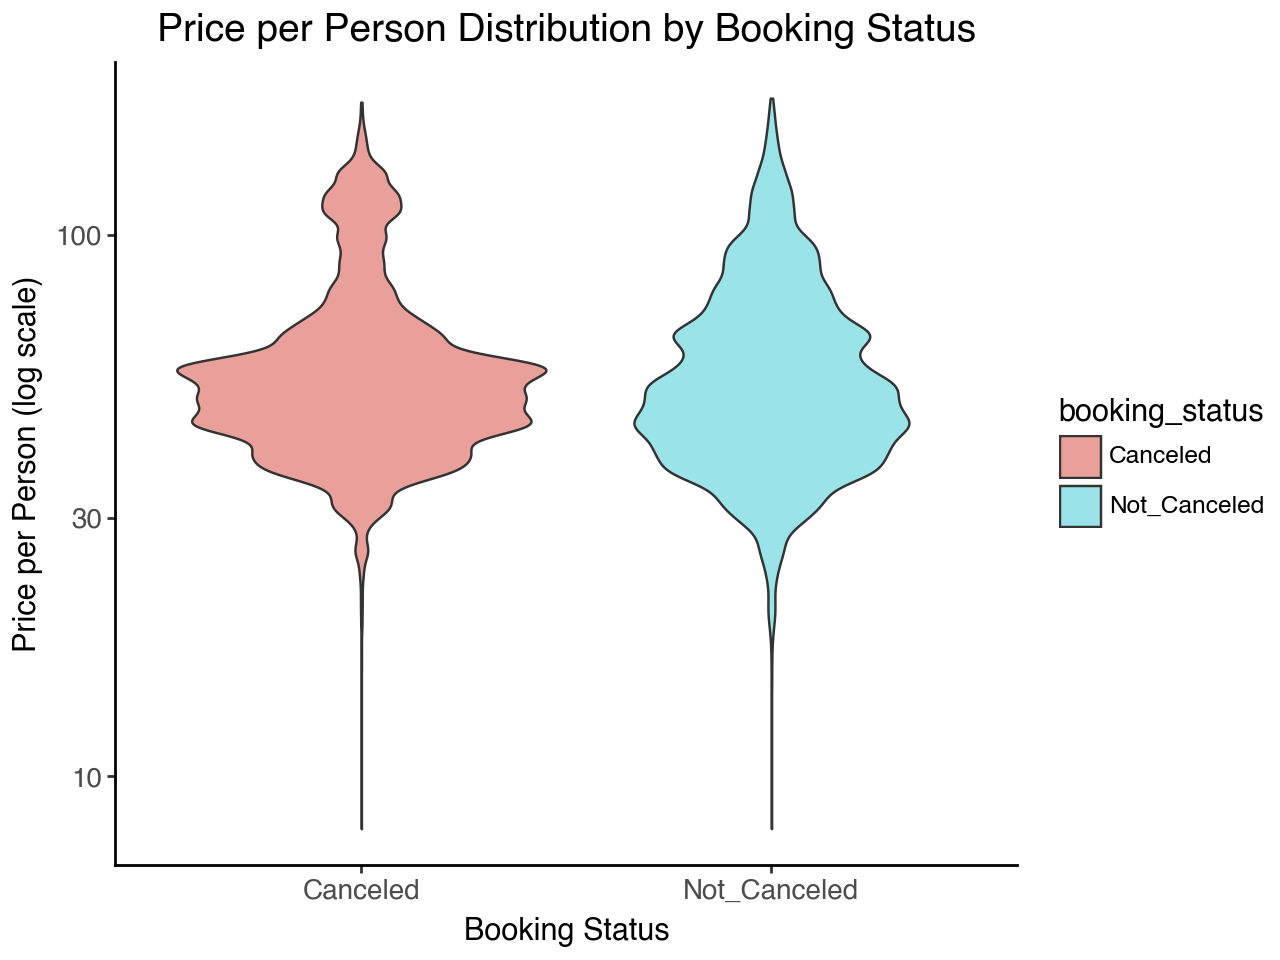

In [252]:
from plotnine import geom_violin

plot_violin = (
    ggplot(df, aes(x='booking_status', y='price_per_person', fill='booking_status')) +
    geom_violin(alpha=0.6) +  # Violin plot for distribution
    scale_y_log10() +  # Log scale for price
    labs(
        title="Price per Person Distribution by Booking Status",
        x="Booking Status",
        y="Price per Person (log scale)"
    ) +
    theme_classic() +
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

print(plot_violin)


<!-- README_INCLUDE -->

- **Price per Room and Person**: On average, users pay 51 euros per room per day and per person in the booking, with the first quartile at 42 euros and the third quartile at 66 euros. There are also some extreme high values in the price distribution. We see a positive correlation but less strong than the total price per day


### Number of special requests

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2648023615.py:9: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


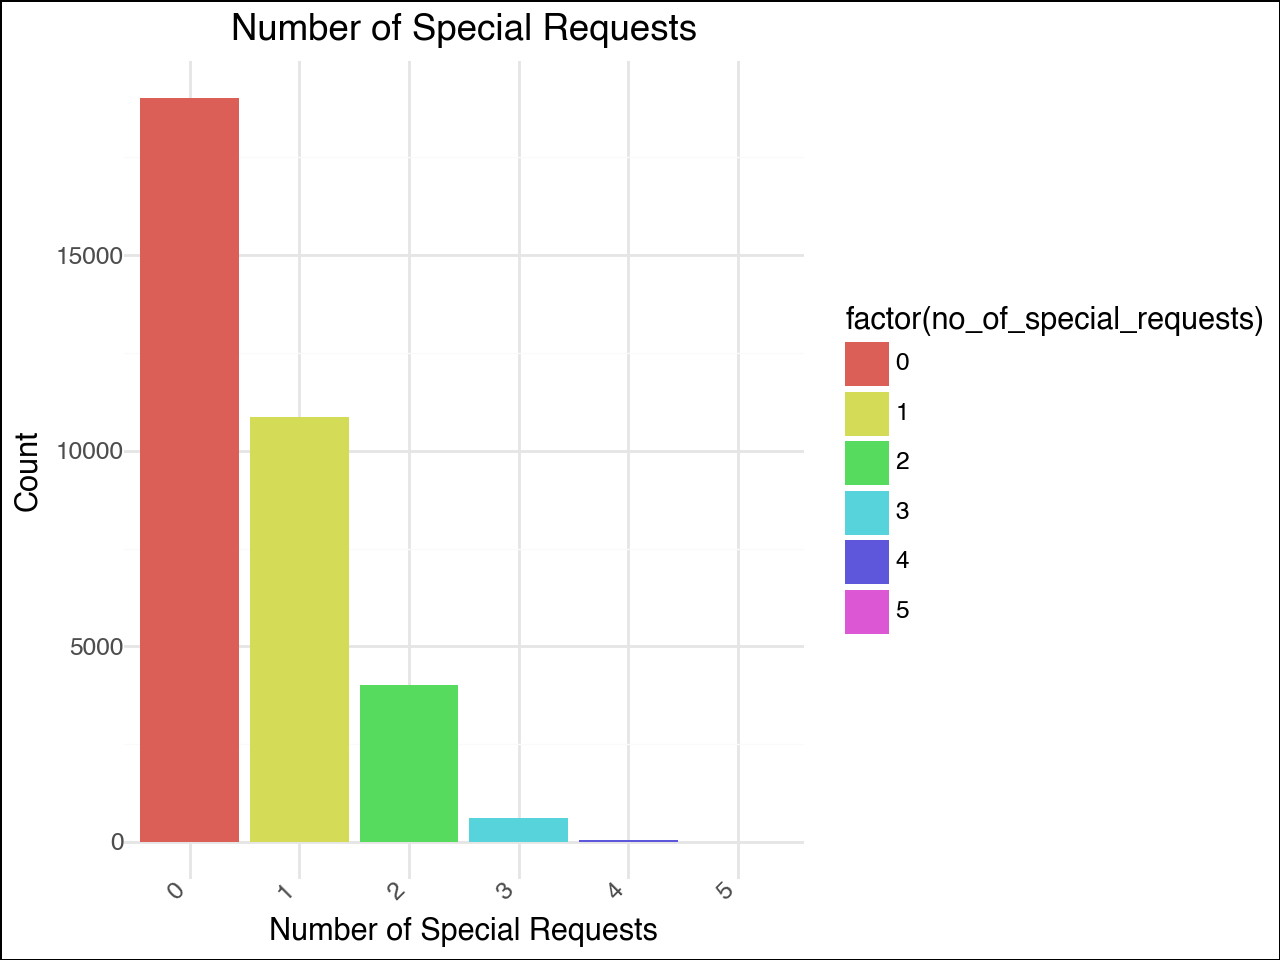

In [253]:
plot = (
    ggplot(df, aes(x='factor(no_of_special_requests)', fill='factor(no_of_special_requests)')) +
    geom_bar() +
    labs(title="Number of Special Requests", x="Number of Special Requests", y="Count") +
    theme_minimal() +
    theme(axis_text_x=element_text(rotation=45, hjust=1),
        plot_background=element_rect(fill='white'))
)
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/646893579.py:18: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


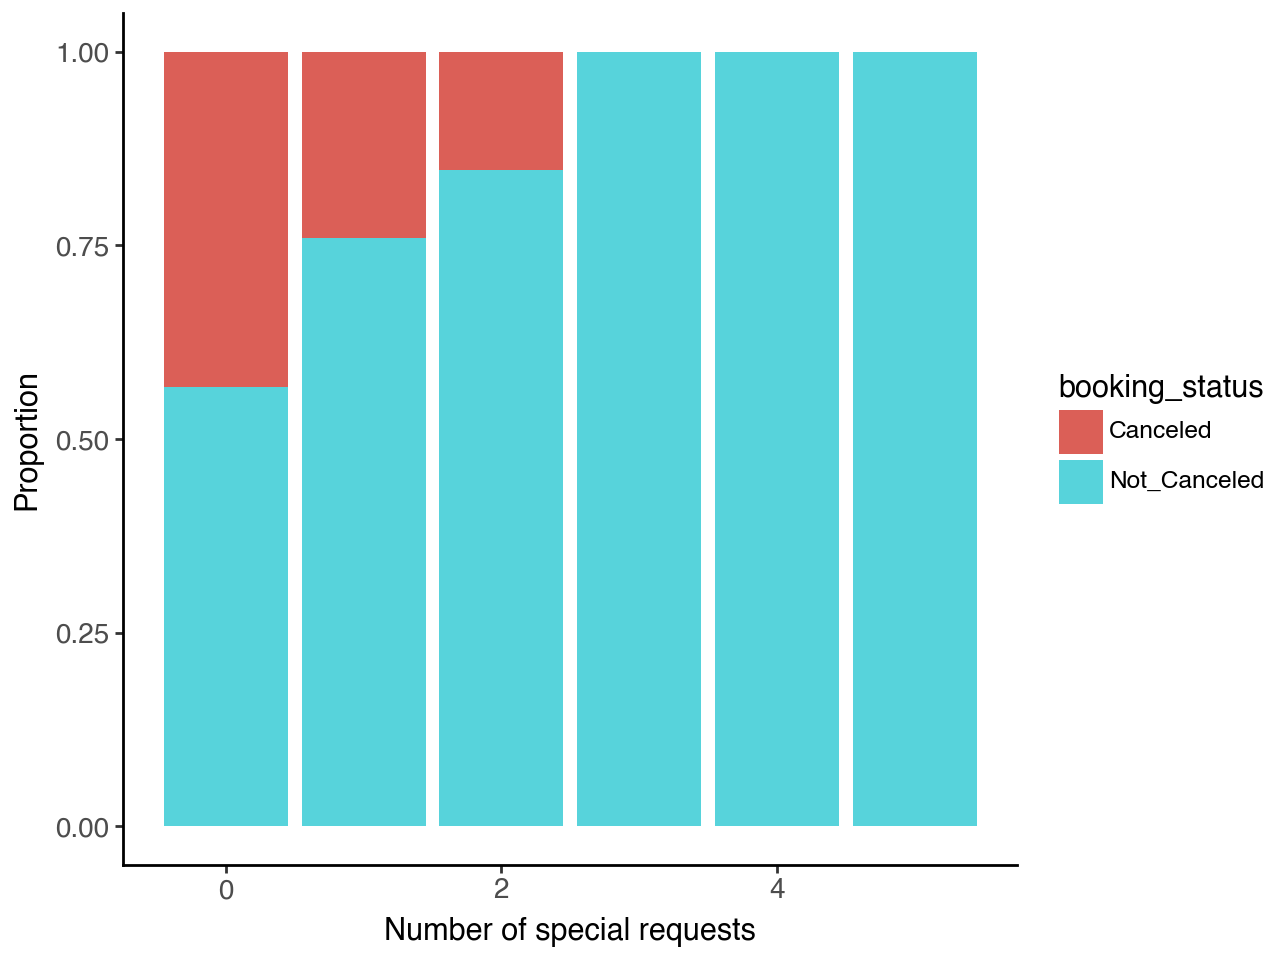

In [254]:
import pandas as pd
from plotnine import ggplot, aes, geom_bar, theme, labs, theme_minimal, element_text


p1 = (
    ggplot(df, aes(x='no_of_special_requests', fill='booking_status')) +  # Set x-axis and fill color by 'tgroup'
    geom_bar(position='fill') +  # Stacked bar plot, filling bars based on proportions
    theme(legend_position='none') +  # Hide the legend
    labs(x="Number of special requests", y="Proportion") +  # Set axis labels
    theme_classic() +  # Use minimal theme
    theme(
        axis_text_x=element_text(size=10),  # X-axis text size
        axis_text_y=element_text(size=10),  # Y-axis text size
        plot_title=element_text(size=14, weight='bold')  # Plot title style
    )
)

print(p1)


<!-- README_INCLUDE -->

- **Number of special Requests**: More special requests correlates with lower cancellation ratio.

### Market segment type

In [255]:
df['market_segment_type'].value_counts(normalize=True)


market_segment_type
Online           0.636106
Offline          0.301799
Corporate        0.058017
Aviation         0.003615
Complementary    0.000463
Name: proportion, dtype: float64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/251204690.py:9: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


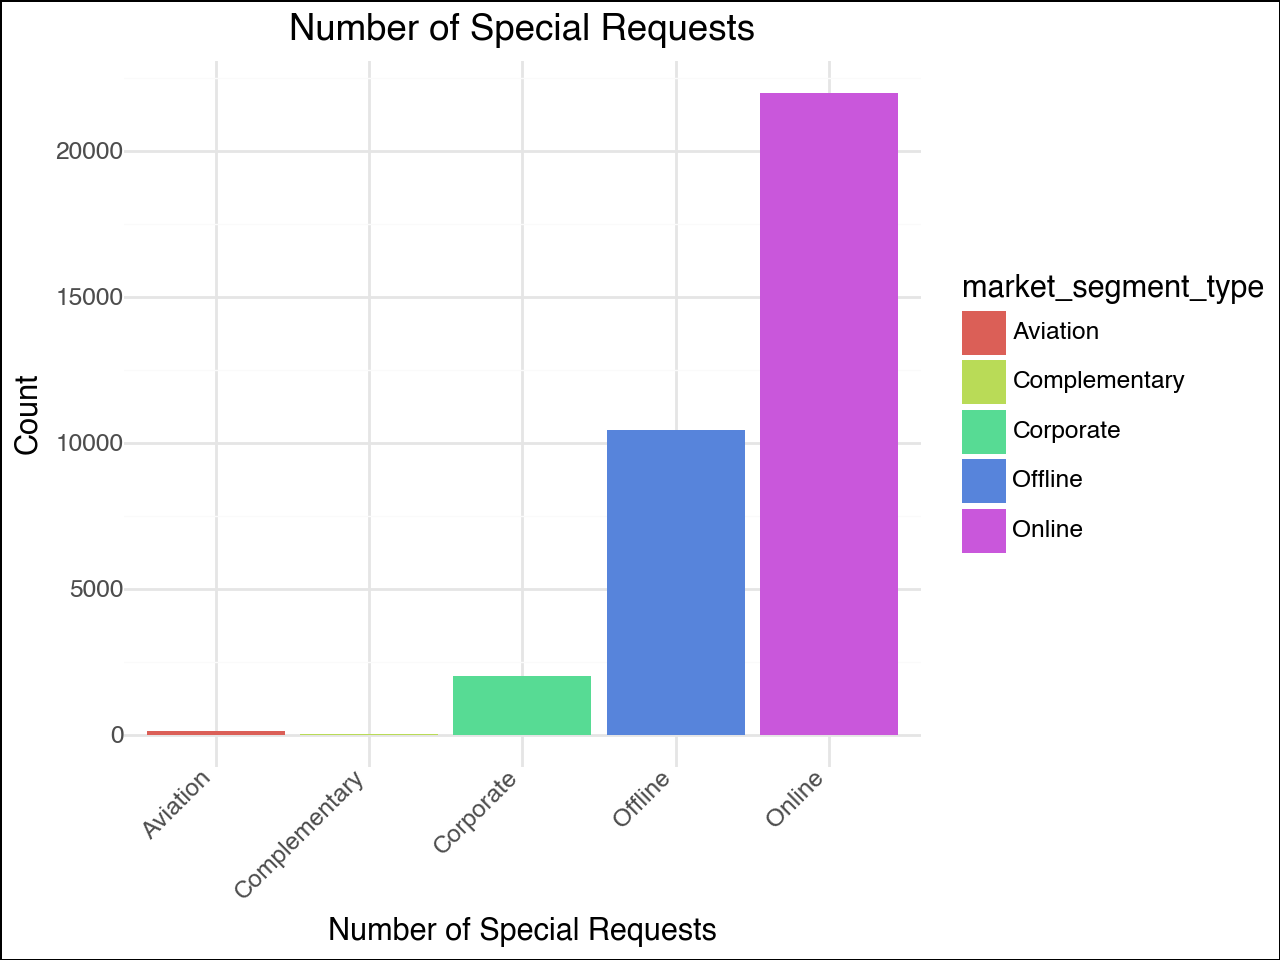

In [256]:
plot = (
    ggplot(df, aes(x='market_segment_type', fill='market_segment_type')) +
    geom_bar() +
    labs(title="Number of Special Requests", x="Number of Special Requests", y="Count") +
    theme_minimal() +
    theme(axis_text_x=element_text(rotation=45, hjust=1),
        plot_background=element_rect(fill='white'))
)
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2449241288.py:18: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


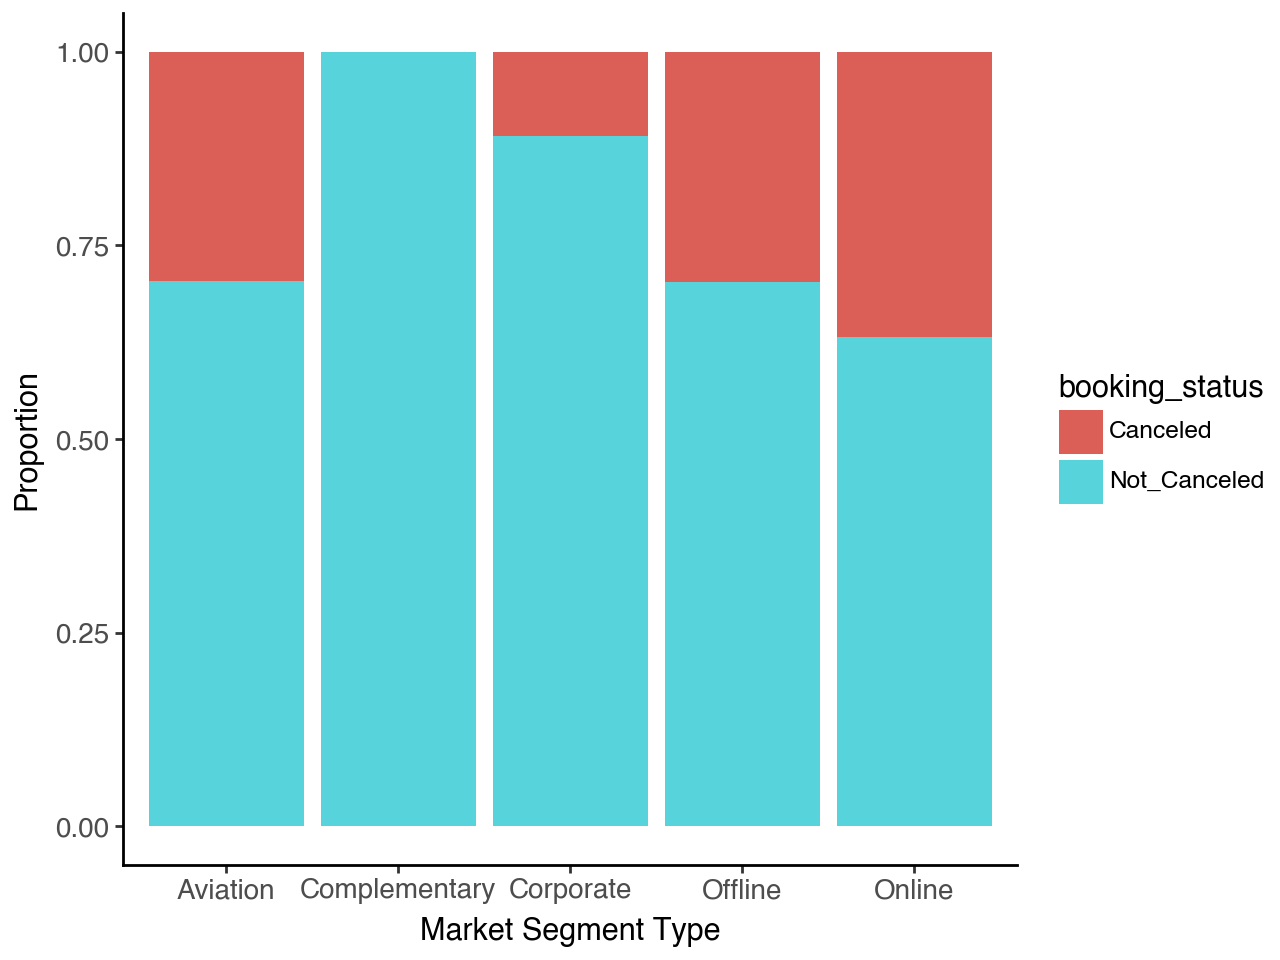

In [257]:
import pandas as pd
from plotnine import ggplot, aes, geom_bar, theme, labs, theme_minimal, element_text


p1 = (
    ggplot(df, aes(x='market_segment_type', fill='booking_status')) +  # Set x-axis and fill color by 'tgroup'
    geom_bar(position='fill') +  # Stacked bar plot, filling bars based on proportions
    theme(legend_position='none') +  # Hide the legend
    labs(x="Market Segment Type", y="Proportion") +  # Set axis labels
    theme_classic() +  # Use minimal theme
    theme(
        axis_text_x=element_text(size=10),  # X-axis text size
        axis_text_y=element_text(size=10),  # Y-axis text size
        plot_title=element_text(size=14, weight='bold')  # Plot title style
    )
)

print(p1)


<!-- README_INCLUDE -->

- **Price per Room**: Most bookings are made online, and these tend to have the highest cancellation ratio. In contrast, bookings made by corporate clients have a lower cancellation ratio, which makes sense since these are typically business trips, and corporate travelers may be less price-sensitive.


### Repeated guest

In [258]:
df['repeated_guest'].value_counts(normalize=True)


repeated_guest
0    0.976949
1    0.023051
Name: proportion, dtype: float64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/4028564384.py:18: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


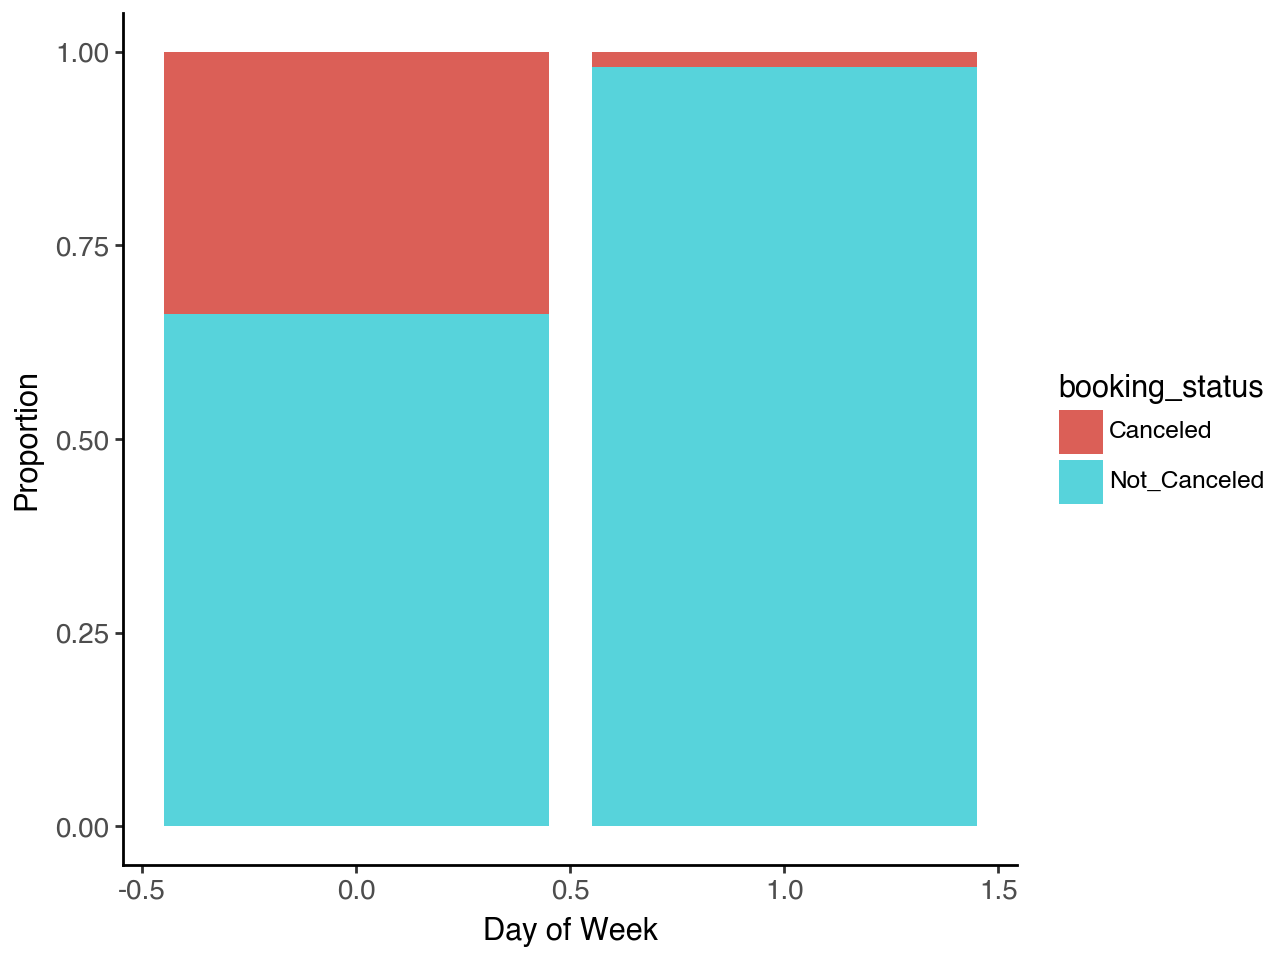

In [259]:
import pandas as pd
from plotnine import ggplot, aes, geom_bar, theme, labs, theme_minimal, element_text


p1 = (
    ggplot(df, aes(x='repeated_guest', fill='booking_status')) +  # Set x-axis and fill color by 'tgroup'
    geom_bar(position='fill') +  # Stacked bar plot, filling bars based on proportions
    theme(legend_position='none') +  # Hide the legend
    labs(x="Day of Week", y="Proportion") +  # Set axis labels
    theme_classic() +  # Use minimal theme
    theme(
        axis_text_x=element_text(size=10),  # X-axis text size
        axis_text_y=element_text(size=10),  # Y-axis text size
        plot_title=element_text(size=14, weight='bold')  # Plot title style
    )
)

print(p1)


<!-- README_INCLUDE -->

- **Repeated Guest**: Repeat guests make up only 2.3% of all bookings, but their cancellation ratio is significantly lower compared to first-time guests.


### number of previous cancellations


In [260]:
df['has_prev_cancellations'].value_counts(normalize=True)


has_prev_cancellations
False    0.991323
True     0.008677
Name: proportion, dtype: float64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2362110731.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


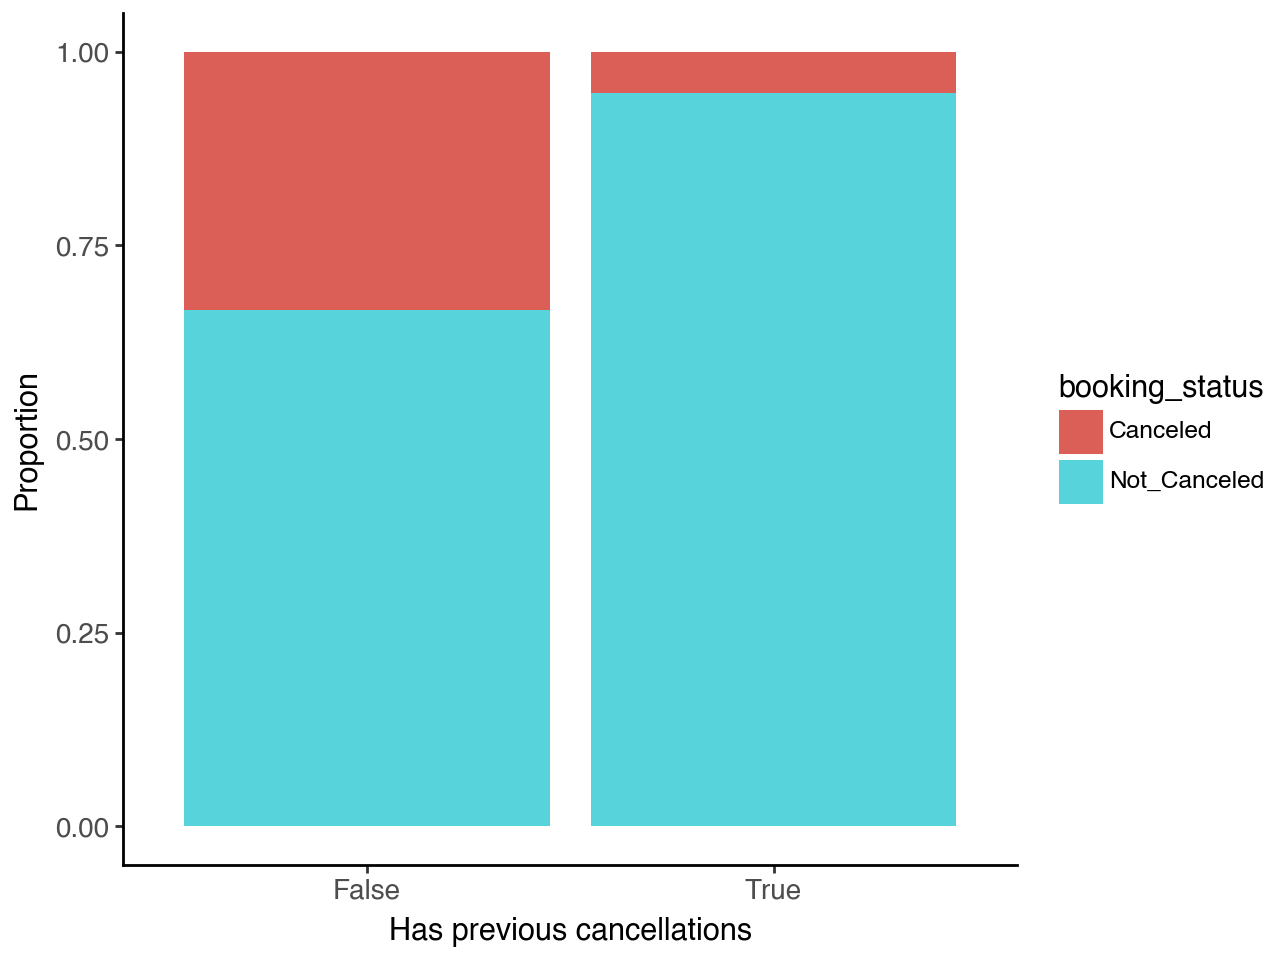

In [261]:

p1 = (
    ggplot(df, aes(x='has_prev_cancellations', fill='booking_status')) +  # Set x-axis and fill color by 'tgroup'
    geom_bar(position='fill') +  # Stacked bar plot, filling bars based on proportions
    theme(legend_position='none') +  # Hide the legend
    labs(x="Has previous cancellations", y="Proportion") +  # Set axis labels
    theme_classic() +  # Use minimal theme
    theme(
        axis_text_x=element_text(size=10),  # X-axis text size
        axis_text_y=element_text(size=10),  # Y-axis text size
        plot_title=element_text(size=14, weight='bold')  # Plot title style
    )
)

print(p1)


<!-- README_INCLUDE -->

- **Has previous cancellations**: Users who cancelled before have less cancellation ratio but also are just a 0.8%.


### required a car parking space

In [262]:
df['required_car_parking_space'].value_counts(normalize=True)

required_car_parking_space
0    0.970818
1    0.029182
Name: proportion, dtype: float64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/2093780681.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


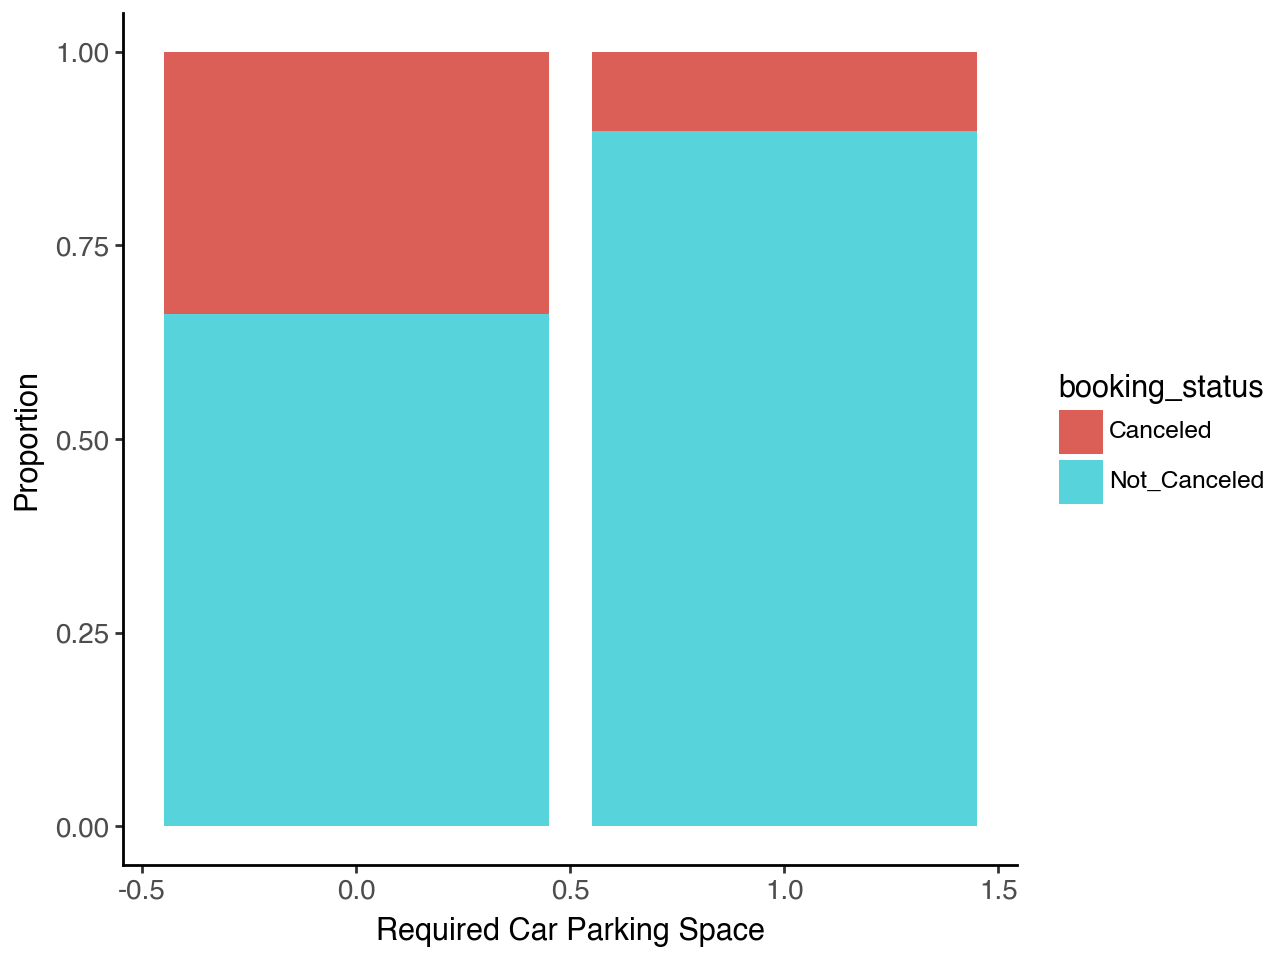

In [263]:
p1 = (
    ggplot(df, aes(x='required_car_parking_space', fill='booking_status')) +  # Set x-axis and fill color by 'tgroup'
    geom_bar(position='fill') +  # Stacked bar plot, filling bars based on proportions
    theme(legend_position='none') +  # Hide the legend
    labs(x="Required Car Parking Space", y="Proportion") +  # Set axis labels
    theme_classic() +  # Use minimal theme
    theme(
        axis_text_x=element_text(size=10),  # X-axis text size
        axis_text_y=element_text(size=10),  # Y-axis text size
        plot_title=element_text(size=14, weight='bold')  # Plot title style
    )
)

print(p1)

<!-- README_INCLUDE -->

- **Required Car Parking Space**: Only 3% of users request parking, but this significantly lowers the cancellation ratio.


### Meals required: 

In [264]:
df['type_of_meal_plan'].value_counts(normalize=True)

type_of_meal_plan
Meal Plan 1     0.765357
Not Selected    0.147096
Meal Plan 2     0.087546
Name: proportion, dtype: float64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/736148756.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


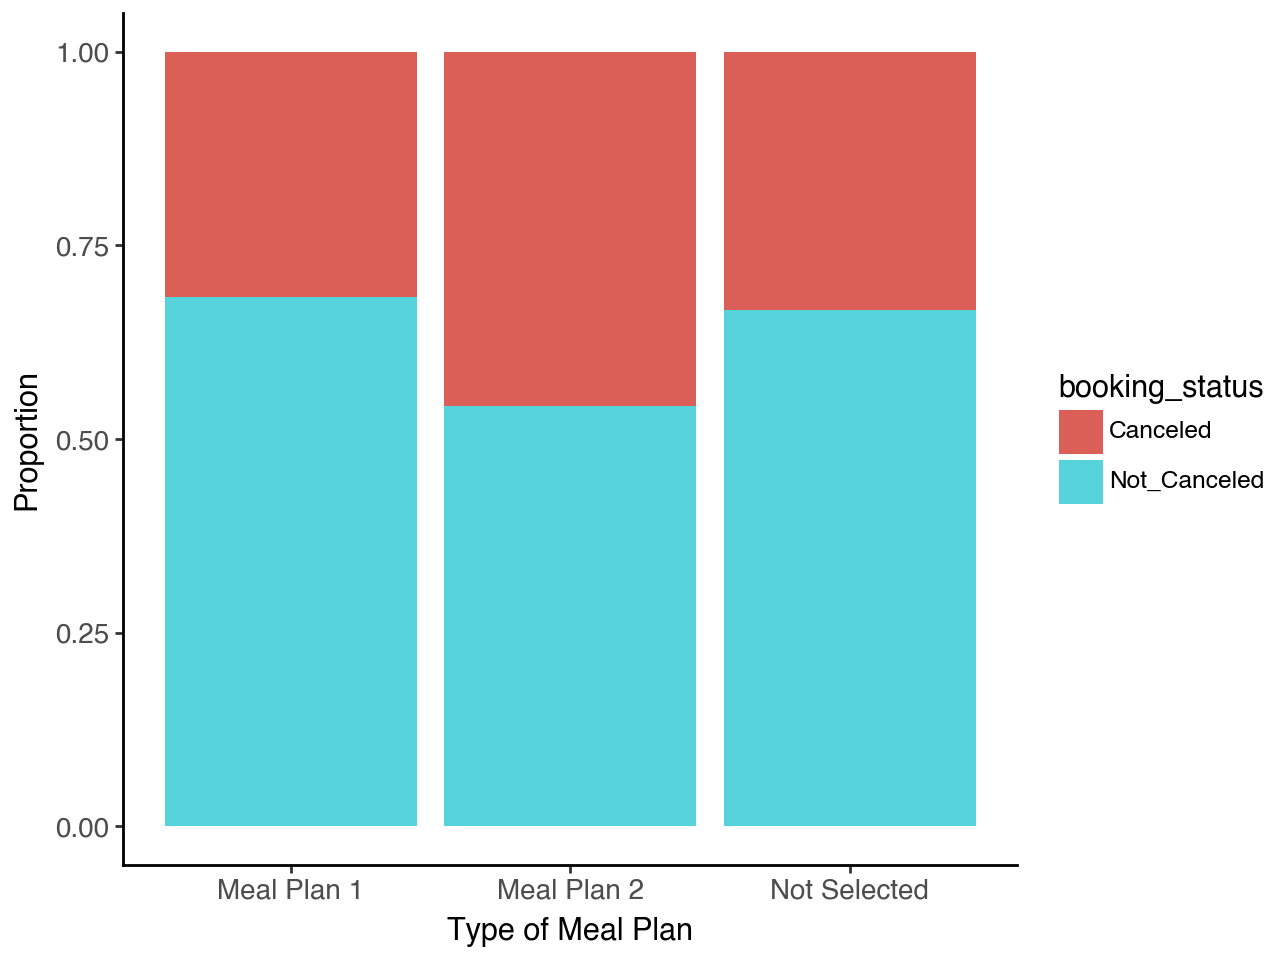

In [265]:
p1 = (
    ggplot(df, aes(x='type_of_meal_plan', fill='booking_status')) +  # Set x-axis and fill color by 'tgroup'
    geom_bar(position='fill') +  # Stacked bar plot, filling bars based on proportions
    theme(legend_position='none') +  # Hide the legend
    labs(x="Type of Meal Plan", y="Proportion") +  # Set axis labels
    theme_classic() +  # Use minimal theme
    theme(
        axis_text_x=element_text(size=10),  # X-axis text size
        axis_text_y=element_text(size=10),  # Y-axis text size
        plot_title=element_text(size=14, weight='bold')  # Plot title style
    )
)

print(p1)

<!-- README_INCLUDE -->

- **Type of Meal Plan**: 76% of users request Meal Type 1, while 8.7% choose Meal Type 2. The remaining 14% do not request a meal. The cancellation ratio is notably higher among users who select Meal Type 2.


### Total nights

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/1442742946.py:7: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


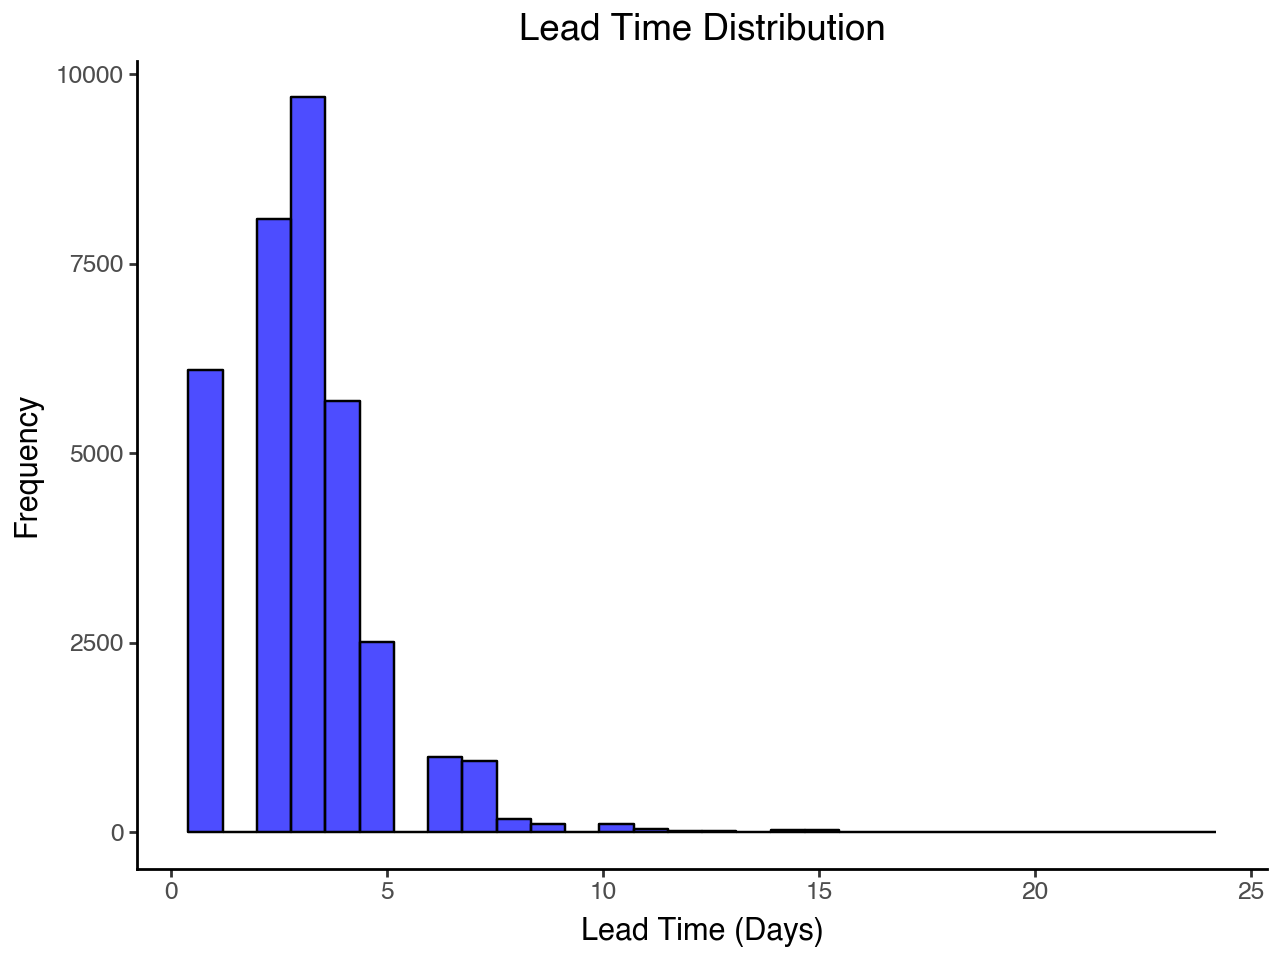

In [266]:

plot = (
    ggplot(df, aes(x='total_nights')) +
    geom_histogram(bins=30, fill='blue', alpha=0.7, color='black') +
    labs(title="Lead Time Distribution", x="Lead Time (Days)", y="Frequency") +
    theme_classic()
)
print(plot)

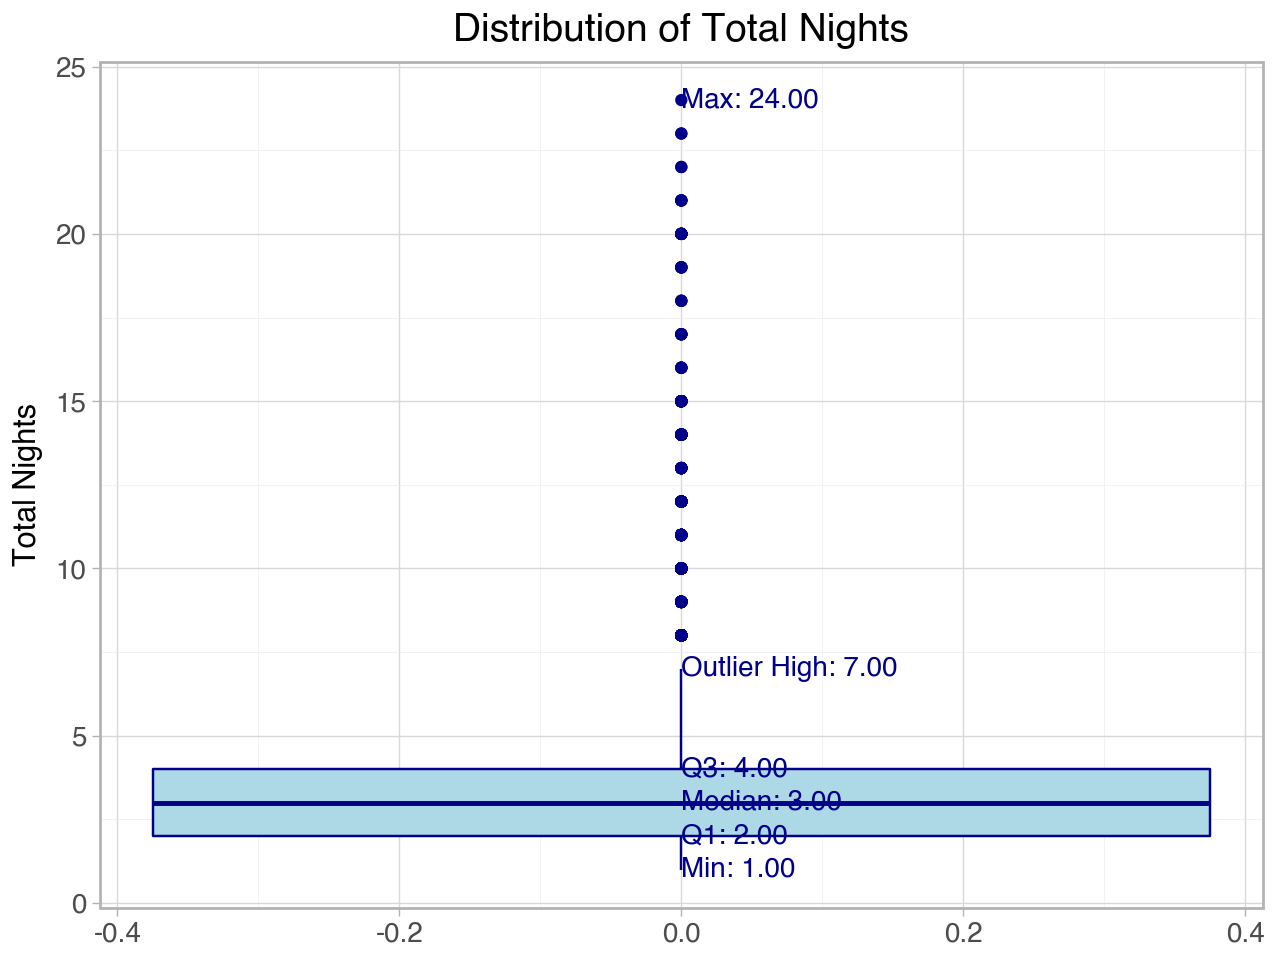

In [267]:
quartiles = df['total_nights'].quantile([0.25, 0.5, 0.75])
median = quartiles[0.5]
q1 = quartiles[0.25]
q3 = quartiles[0.75]
outhigh = q3 + 1.5 * (q3 - q1)
min_value = df['total_nights'].min()
max_value = df['total_nights'].max()

labels_data = pd.DataFrame({
    'x': [0, 0, 0, 0, 0,  0],  # Slight offset from the box to position labels next to the lines
    'y': [median, q1, q3, min_value, max_value, outhigh],
    'label': [
        f'Median: {median:.2f}',
        f'Q1: {q1:.2f}',
        f'Q3: {q3:.2f}',
        f'Min: {min_value:.2f}',
        f'Max: {max_value:.2f}',
        f'Outlier High: {outhigh:.2f}'
    ]
})

plot = (
    ggplot(df, aes(y='total_nights')) +  # Only the y-axis is the avg price per room
    geom_boxplot(fill='lightblue', color='darkblue') +  # Boxplot with light blue fill and dark blue outline
    geom_text(
        aes(x='x', y='y', label='label'),  # Set the x, y, and label aesthetics
        data=labels_data,  # Pass the labels_data DataFrame for the label positions
        va='center', ha='left', size=10, color='darkblue', fontweight='bold'
    ) +
    labs(
        title="Distribution of Total Nights",
        x="",
        y="Total Nights"
    ) +
    theme_light() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),  # No x-axis labels as there's only one variable
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

plot.show()


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/255512494.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


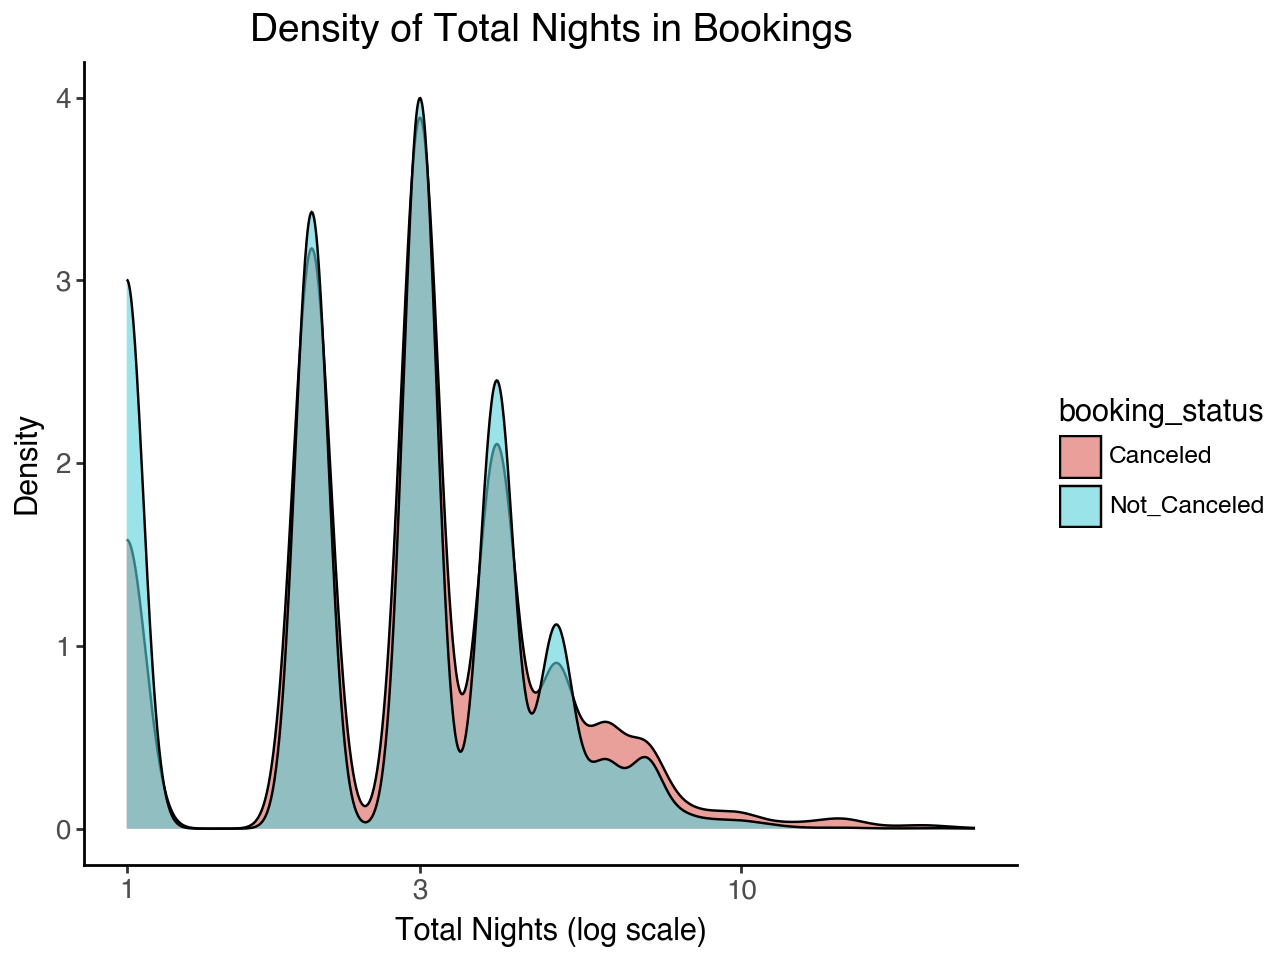

In [268]:
plot = (
    ggplot(df, aes(x='total_nights', fill='booking_status')) +
    geom_density(alpha=0.6) +  # Density plot with alpha transparency
    scale_x_log10() +  # Logarithmic scale for x-axis
    labs(
        title="Density of Total Nights in Bookings",
        x="Total Nights (log scale)",
        y="Density"
    ) +
    theme_classic() +  # Clean white background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/3864642781.py:27: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


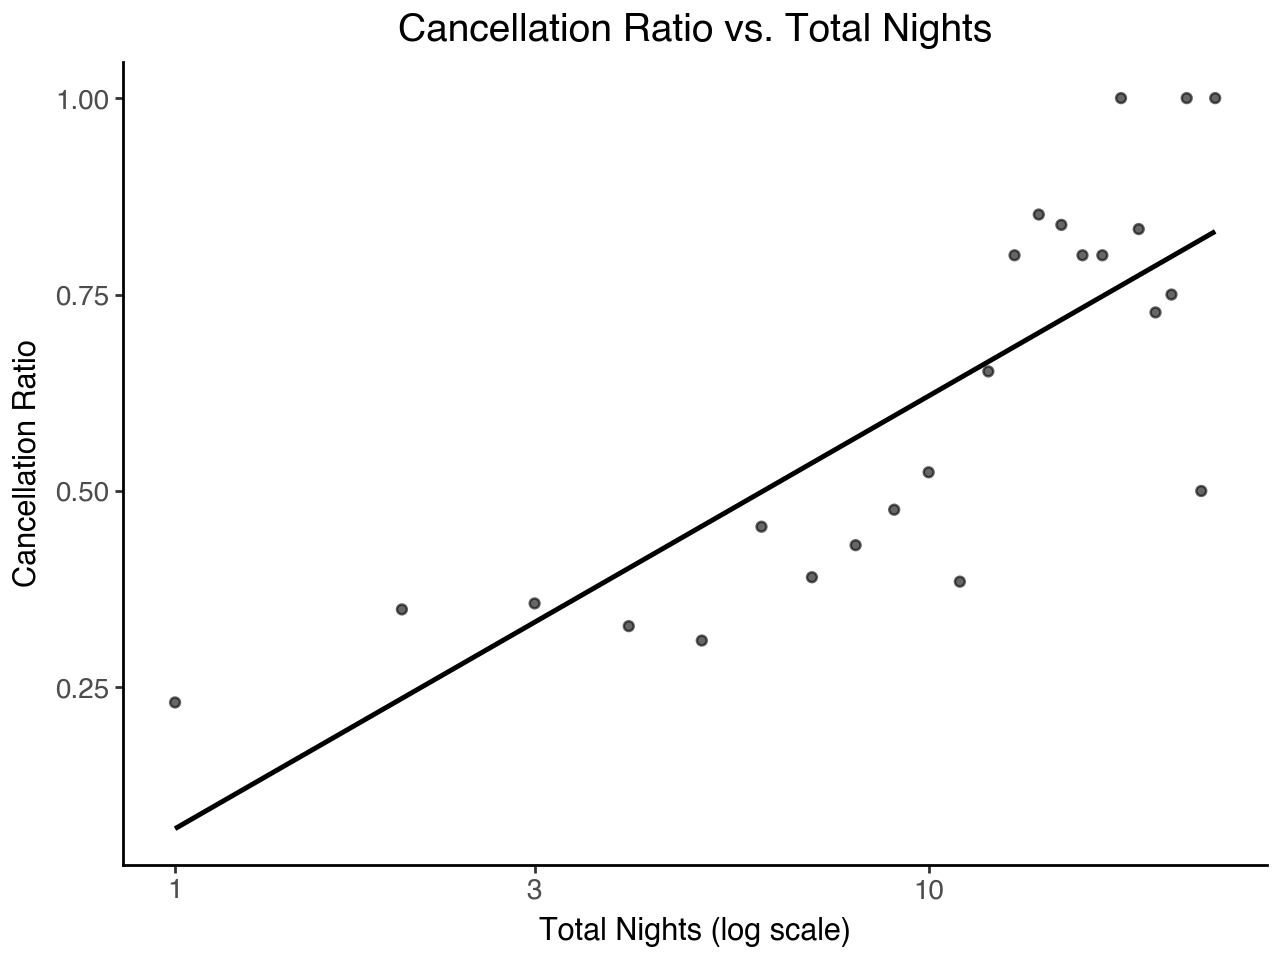

In [270]:
from plotnine import ggplot, aes, geom_point, geom_smooth, scale_x_log10, labs, theme_classic, theme, element_text, facet_wrap

cancellation_data = (   
    df.groupby('total_nights')['booking_status']
    .apply(lambda x: (x == 'Canceled').sum() / len(x))
    .reset_index(name='cancellation_ratio')
)

plot = (
    ggplot(cancellation_data, aes(x='total_nights', y='cancellation_ratio')) +
    geom_point(alpha=0.6) +  # Scatter plot with transparency
    geom_smooth(method='lm', se=False, color='black') +  # Add a linear regression line
    scale_x_log10() +  # Logarithmic scale for the x-axis
    labs(
        title="Cancellation Ratio vs. Total Nights",
        x="Total Nights (log scale)",
        y="Cancellation Ratio"
    ) +
    theme_classic() +  # Classic theme for a clean background
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

print(plot)


<!-- README_INCLUDE -->

- **Total Nights**: On average, users stay for three nights, with the first quartile at two nights and the third quartile at four nights. Users staying for just one night have a significantly lower cancellation ratio. However, the cancellation ratio increases notably for stays longer than five nights.


### weekends - weekdays distribution

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/1135267422.py:18: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


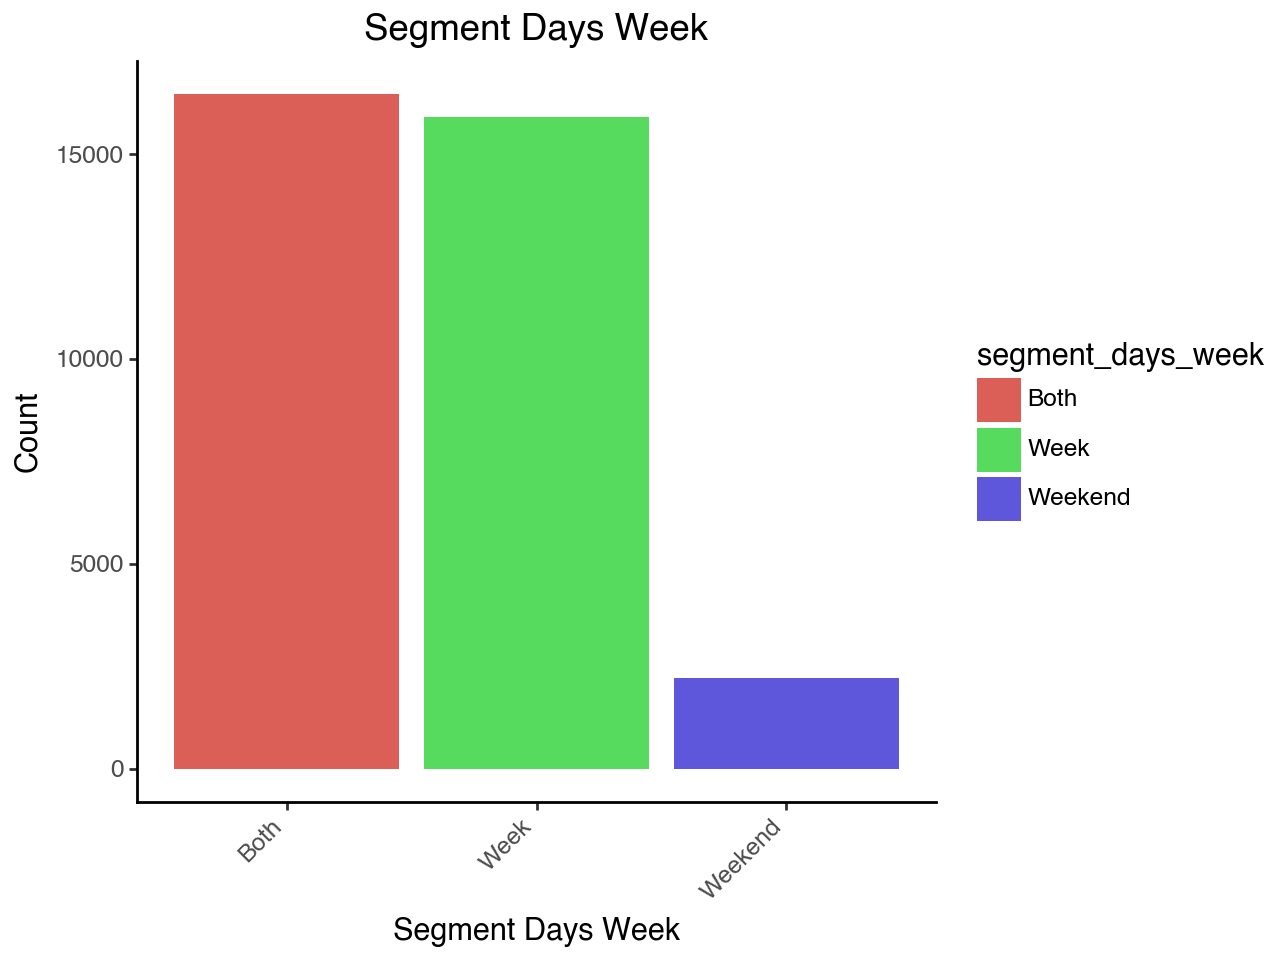

In [ ]:
import numpy as np
from plotnine import ggplot, aes, geom_bar, theme_minimal, element_text

df['segment_days_week'] =np.where(
    (df['no_of_weekend_nights'] > 0) & (df['no_of_week_nights'] > 0),  'Both',
        np.where(df['no_of_weekend_nights'] > 0, 'Weekend', 'Week')
    )


plot = (
    ggplot(df, aes(x='segment_days_week', fill='segment_days_week')) +
    geom_bar() +
    labs(title="Segment Days Week", x="Segment Days Week", y="Count") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

print(plot)


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/408417228.py:28: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


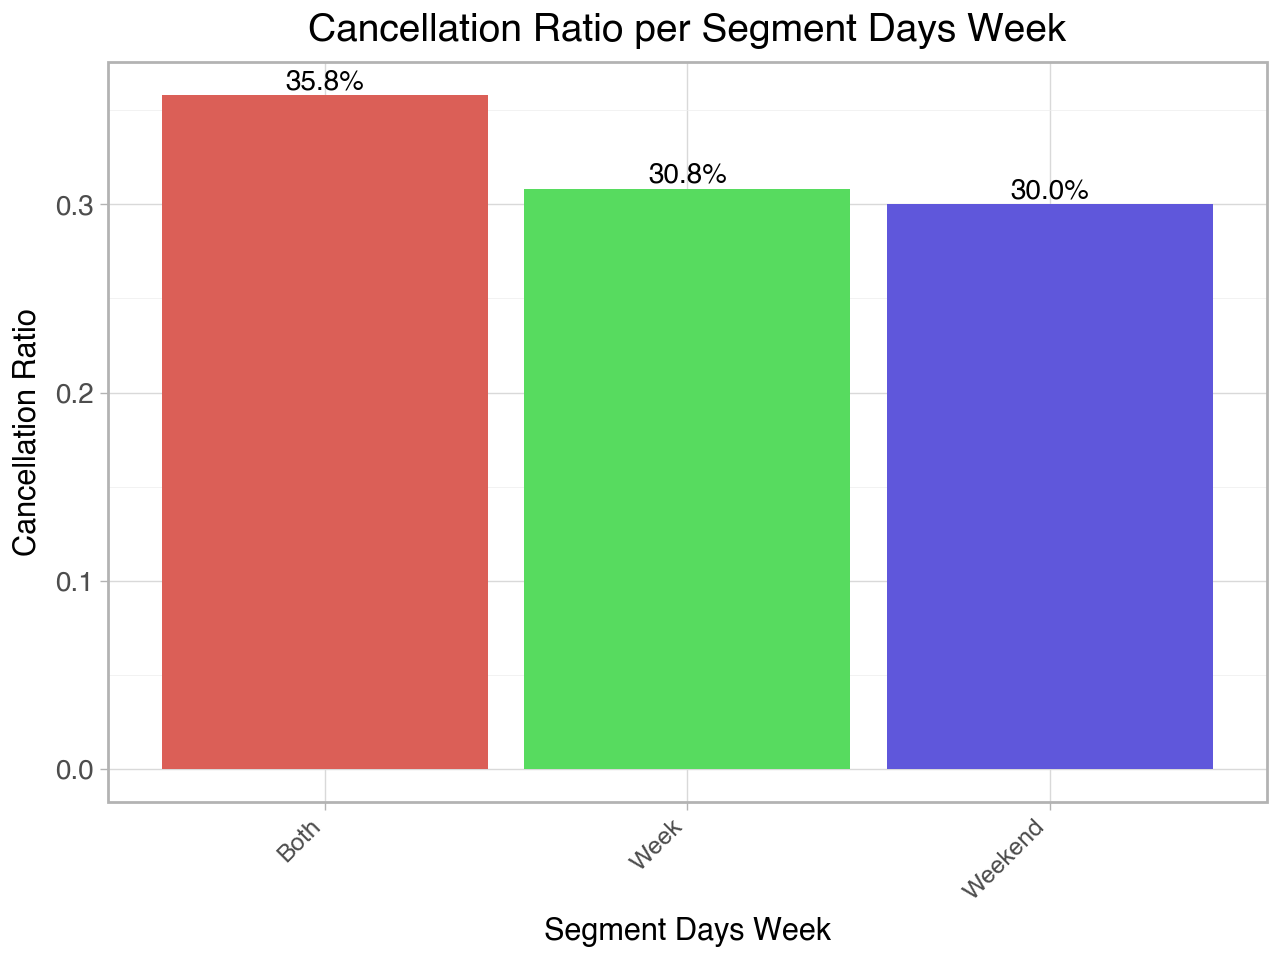

In [ ]:
cancellation_data = (
    df.groupby('segment_days_week')['booking_status']
    .apply(lambda x: (x == 'Canceled').sum() / len(x))
    .reset_index(name='cancellation_ratio')
)

cancellation_data['cancellation_ratio_percentage'] = (cancellation_data['cancellation_ratio'] * 100).round(1)

plot = (
    ggplot(cancellation_data, aes(x='segment_days_week', y='cancellation_ratio', fill='segment_days_week')) +
    geom_col(show_legend=False) +
    geom_text(
        aes(label=cancellation_data['cancellation_ratio_percentage'].astype(str) + '%'),
        va='bottom', size=10
    ) +
    labs(
        title="Cancellation Ratio per Segment Days Week",
        x="Segment Days Week",
        y="Cancellation Ratio"
    ) +
    theme_light() +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)
print(plot)

<!-- README_INCLUDE -->

- **Type of Stay in Terms of Weekday-Weekend**: Around half of the bookings include both weekdays and weekends, while a similar proportion are for weekdays only. Bookings for weekends alone are relatively rare. The cancellation ratio is higher for stays that include both weekdays and weekends compared to the other two categories.


### children

In [ ]:
df['have_children'].value_counts(normalize=True)


have_children
False    0.940479
True     0.059521
Name: proportion, dtype: float64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/1861985765.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


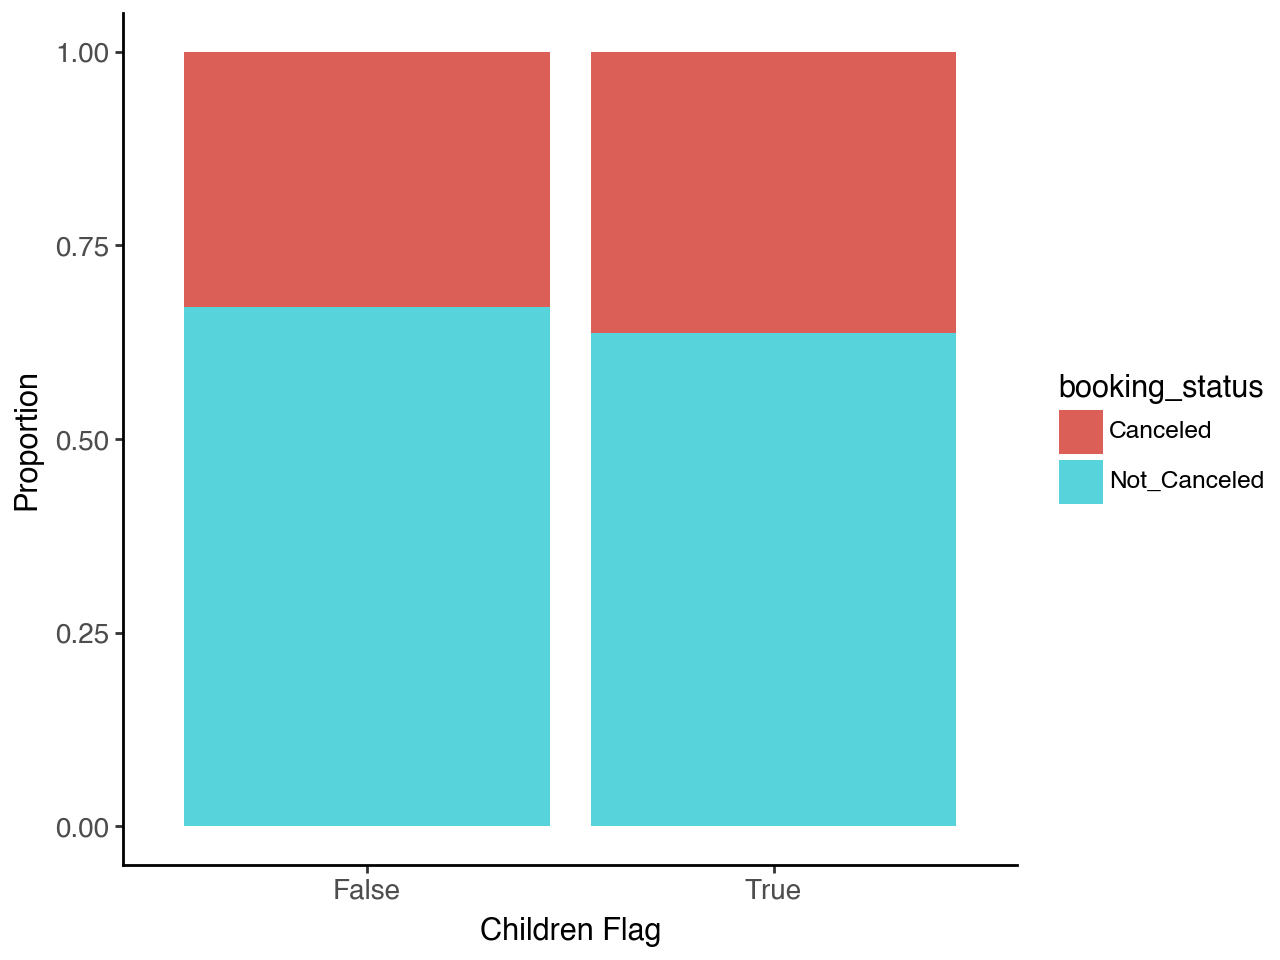

In [ ]:
p1 = (
    ggplot(df, aes(x='have_children', fill='booking_status')) +  # Set x-axis and fill color by 'tgroup'
    geom_bar(position='fill') +  # Stacked bar plot, filling bars based on proportions
    theme(legend_position='none') +  # Hide the legend
    labs(x="Children Flag", y="Proportion") +  # Set axis labels
    theme_classic() +  # Use minimal theme
    theme(
        axis_text_x=element_text(size=10),  # X-axis text size
        axis_text_y=element_text(size=10),  # Y-axis text size
        plot_title=element_text(size=14, weight='bold')  # Plot title style
    )
)
print(p1)

<!-- README_INCLUDE -->
- **Type of Stay in Terms of Weekday-Weekend**: Stays with children account for just 6%, with a slightly higher chance of cancellation.

### Month of the year and day of the week starting the booking

In [272]:
import pandas as pd

# Function to check if the year is a leap year
def is_leap_year(year):
    return (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0))

# Function to adjust the date if it's February 29th in a non-leap year
def adjust_for_feb_29(year, month, day):
    # If it's February 29 and not a leap year, change to February 28
    if month == 2 and day == 29 and not is_leap_year(year):
        return (month, 28)  # Change to February 28th
    return (month, day)

# Ensure the month and day are zero-padded
df['arrival_month'] = df['arrival_month'].apply(lambda x: f'{int(x):02d}')
df['arrival_date'] = df['arrival_date'].apply(lambda x: f'{int(x):02d}')

# Adjust dates where necessary
df[['arrival_month', 'arrival_date']] = df.apply(
    lambda row: adjust_for_feb_29(row['arrival_year'], row['arrival_month'], row['arrival_date']), axis=1,
    result_type='expand'
)

# Check the rows with invalid 'arrival_date_complete' (those with NaN)
df['arrival_date_complete'] = pd.to_datetime(
    df[['arrival_year', 'arrival_month', 'arrival_date']].astype(str).agg('-'.join, axis=1),
    format='%Y-%m-%d', errors='coerce'
)

# Inspect the rows where arrival_date_complete is NaN
invalid_dates = df[df['arrival_date_complete'].isnull()]
print(f"Invalid dates found:\n{invalid_dates[['arrival_year', 'arrival_month', 'arrival_date']]}")

# Check how many nulls are present
null_count = df['arrival_date_complete'].isnull().sum()
print(f"Number of null values in arrival_date_complete: {null_count}")


Invalid dates found:
       arrival_year arrival_month arrival_date
2626           2018            02           29
3677           2018            02           29
5600           2018            02           29
6343           2018            02           29
7648           2018            02           29
8989           2018            02           29
9245           2018            02           29
9664           2018            02           29
9934           2018            02           29
10593          2018            02           29
10652          2018            02           29
10747          2018            02           29
11881          2018            02           29
14304          2018            02           29
15363          2018            02           29
15438          2018            02           29
17202          2018            02           29
18380          2018            02           29
18534          2018            02           29
18680          2018            02      

In [273]:
# change null values to 28th of February 2018
df['arrival_date_complete'] = df['arrival_date_complete'].fillna(pd.to_datetime('2018-02-28'))

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/4095557788.py:26: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


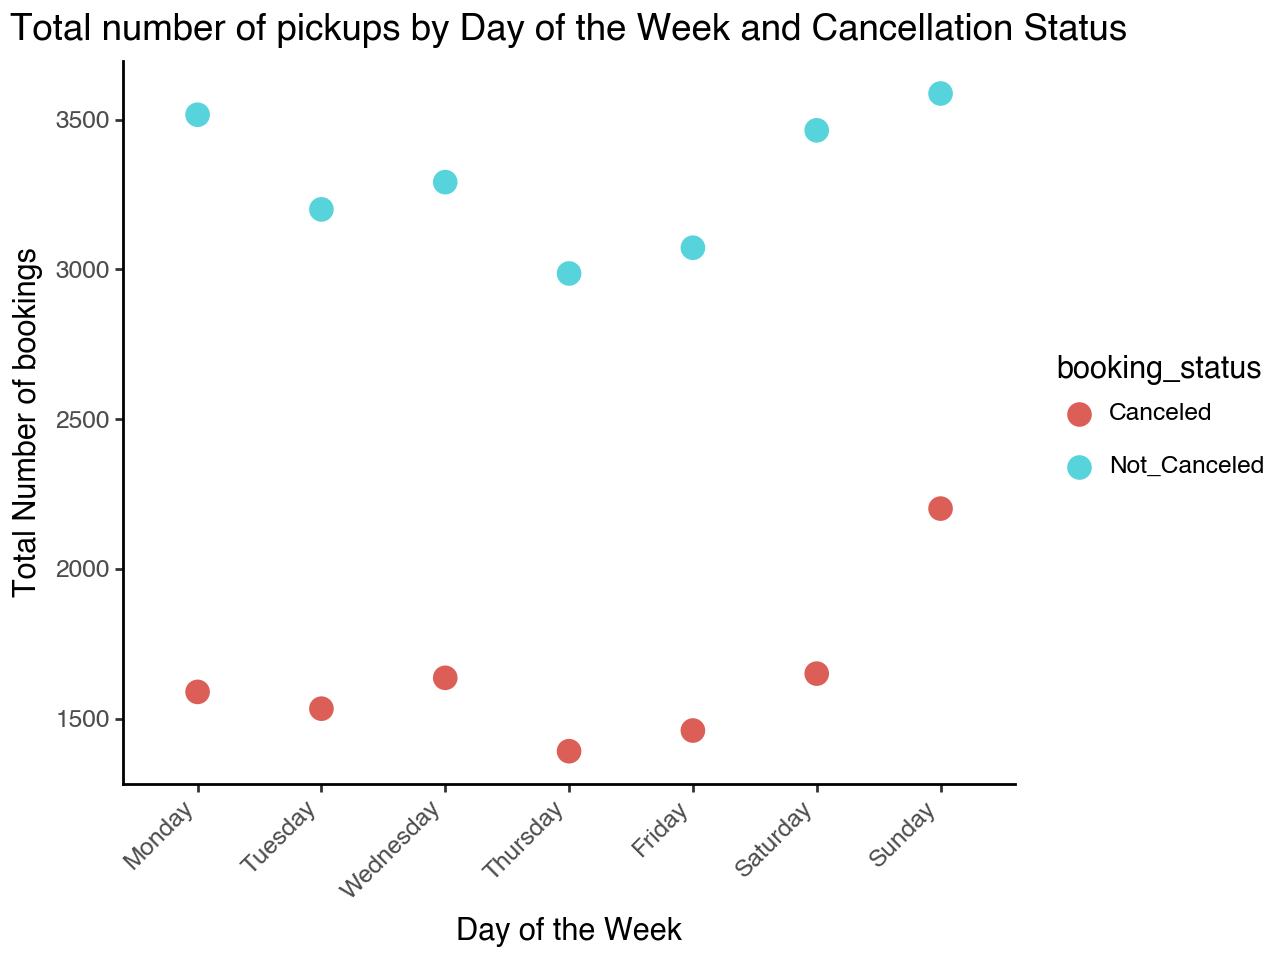

In [279]:
from plotnine import  geom_point, scale_x_discrete


# Assuming 'df' is your DataFrame and it has 'pickup_datetime' and 'cancellation_status' columns
# Ensure 'pickup_datetime' is a datetime column
df['arrival_date_complete'] = pd.to_datetime(df['arrival_date_complete'])

# Extract day of the week (1 is Monday, 7 is Sunday)
df['wday'] = df['arrival_date_complete'].dt.day_name()

# Group by 'wday' and 'cancellation_status', then count the occurrences
df_grouped = df.groupby(['wday', 'booking_status']).size().reset_index(name='n')

# Plot with plotnine (ggplot-like syntax)
plot = (
    ggplot(df_grouped, aes(x='wday', y='n', color='booking_status')) +
    geom_point(size=4) +
    labs(x="Day of the Week", y="Total Number of bookings", title="Total number of pickups by Day of the Week and Cancellation Status") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +  # Rotate x-axis labels
    scale_x_discrete(limits=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])  # Order x-axis
)

# Show the plot
print(plot)

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_34314/1385537799.py:28: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


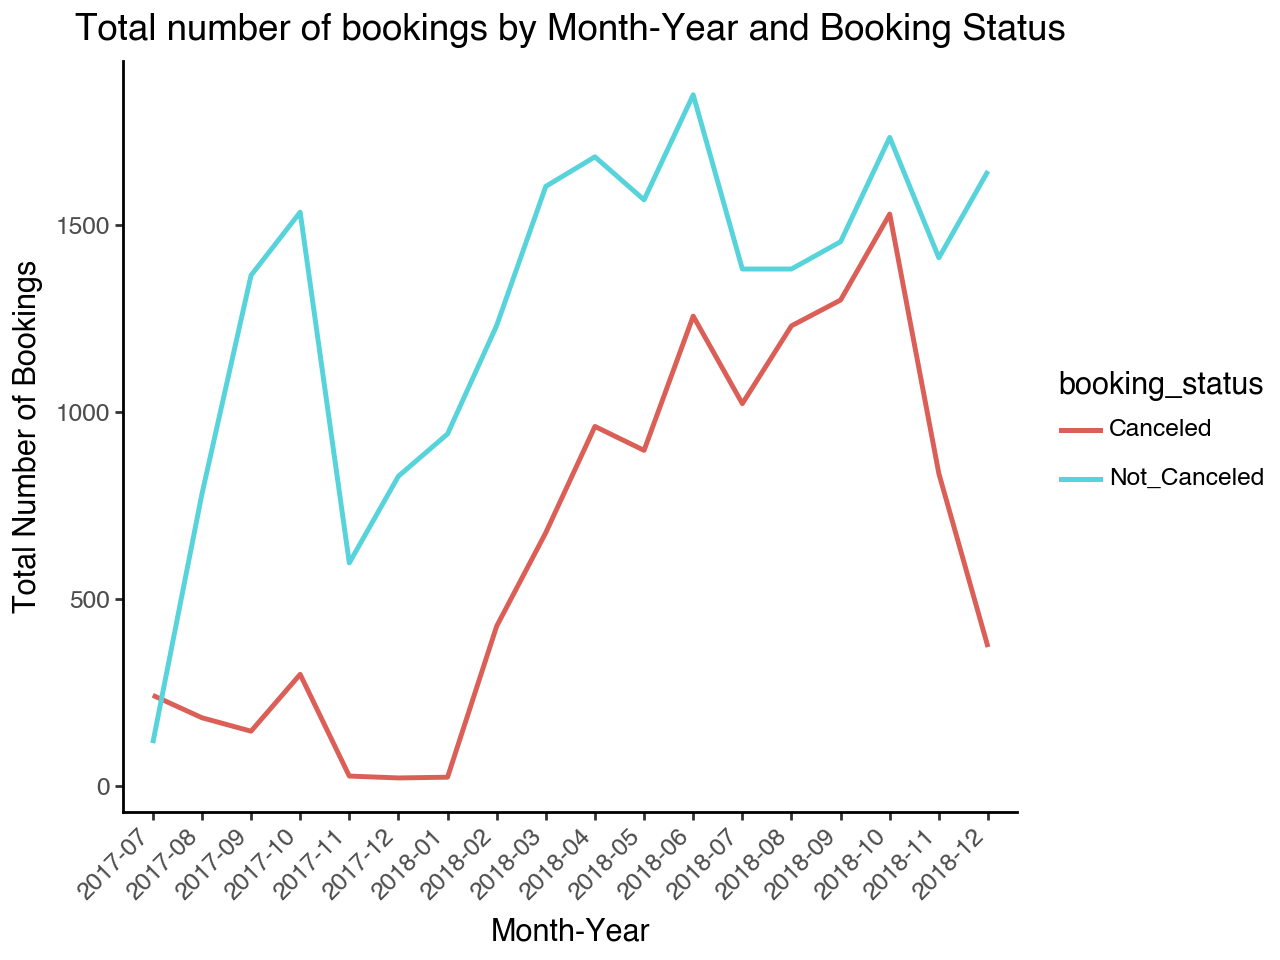

In [280]:
import pandas as pd
from plotnine import geom_line

# Assuming 'df' is your DataFrame and it has 'arrival_date_complete' and 'booking_status' columns
# Ensure 'arrival_date_complete' is a datetime column
df['arrival_date_complete'] = pd.to_datetime(df['arrival_date_complete'])

# Extract month-year (formatted as 'YYYY-MM')
df['month_year'] = df['arrival_date_complete'].dt.to_period('M').astype(str)

# Group by 'month_year' and 'booking_status', then count the occurrences
df_grouped = df.groupby(['month_year', 'booking_status']).size().reset_index(name='n')

# Plot with plotnine (ggplot-like syntax) using geom_line
plot = (
    ggplot(df_grouped, aes(x='month_year', y='n', color='booking_status', group='booking_status')) +
    geom_line(size=1) +  # Use a line instead of points
    labs(
        x="Month-Year", 
        y="Total Number of Bookings", 
        title="Total number of bookings by Month-Year and Booking Status"
    ) +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))  # Rotate x-axis labels for better readability
)

# Show the plot
print(plot)


<!-- README_INCLUDE -->
- **Arrival Day of the Week**: Bookings with arrival dates on Sundays exhibit a significantly higher likelihood of cancellation compared to other days. This observation highlights an association between the day of the week and cancellation tendencies.

- **Arrival Month of the Year**: A noticeable increase in cancellation rates is observed during the summer months, suggesting a seasonal trend in booking behavior.

----


## 3. 